In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold,train_test_split
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

import gc

%matplotlib inline

In [24]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [45]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))


Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 60.95 MB
Decreased by 77.2%
Memory usage of dataframe is 70.78 MB
Memory usage after optimization is: 16.49 MB
Decreased by 76.7%


In [46]:
def seed_everything(seed=0):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
SEED = 42
seed_everything(SEED)

In [47]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [48]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(train_df, test_df, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train_df[[col]], test_df[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train_df[col] = train_df[col].map(fq_encode)
            test_df[col]  = test_df[col].map(fq_encode)            
        else:
            train_df[col+'_FE'] = train_df[col].map(fq_encode)
            #print(train_df[col+'_FE'].sort_index().head())
            test_df[col+'_FE']  = test_df[col].map(fq_encode)
    return train_df, test_df
#encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

In [49]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [50]:
# GROUP AGGREGATION MEAN AND STD
def group_ag(by_group_cols,groupby_cols,df1,df2,aggregations=['mean'],fillna=True):
    for bycol in by_group_cols:
        for groupcol in groupby_cols:
            for agg_type in aggregations:
                nm = bycol+'_'+ groupcol +'_'+agg_type
                temp_df = pd.concat([df1[[groupcol, bycol]], df2[[groupcol,bycol]]])
                temp_df = temp_df.groupby([groupcol])[bycol].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: nm})                
                temp_df.index = list(temp_df[groupcol])
                temp_df = temp_df[nm].to_dict()   

                df1[nm] = df1[groupcol].map(temp_df).astype('float32')
                df2[nm] = df2[groupcol].map(temp_df).astype('float32')
                
                if fillna:
                    df1[nm].fillna(-1,inplace=True)
                    df2[nm].fillna(-1,inplace=True)    
                print("'"+nm+"'",', ',end='')
   
#group_ag(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],df,df2,['mean','std'])

In [51]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [52]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [53]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [54]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols

['contp',
 'flbmk',
 'flg_3dsmk',
 'fraud_ind',
 'hcefg',
 'insfg',
 'iterm',
 'ovrlt',
 'stscd']

In [55]:
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [56]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [20]:
#use label encoding
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('flbmk')
cat_cols.remove('flg_3dsmk')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

-100.0    1.0
Name: flbmk, dtype: float64
-100.0    1.0
Name: flg_3dsmk, dtype: float64


-100.0    1.0
Name: flg_3dsmk, dtype: float64

In [57]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [58]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [59]:
#change_time(df)
#change_time(df_test)
df.columns
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

## 現階段訓練測試集分布


C:\Users\kiwi\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


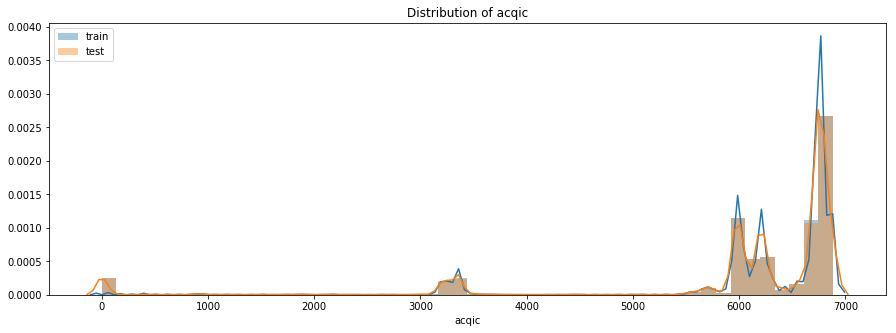

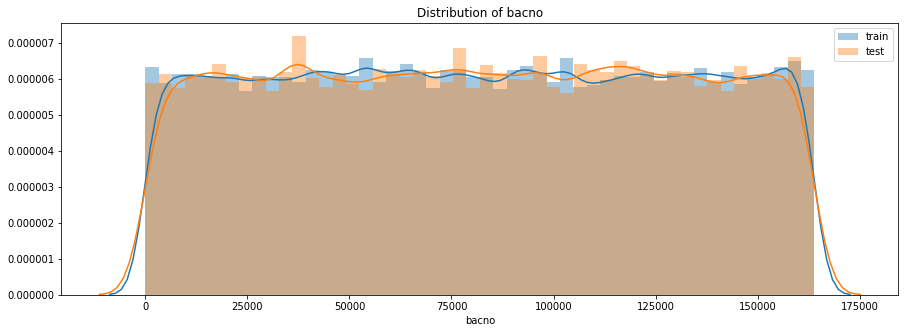

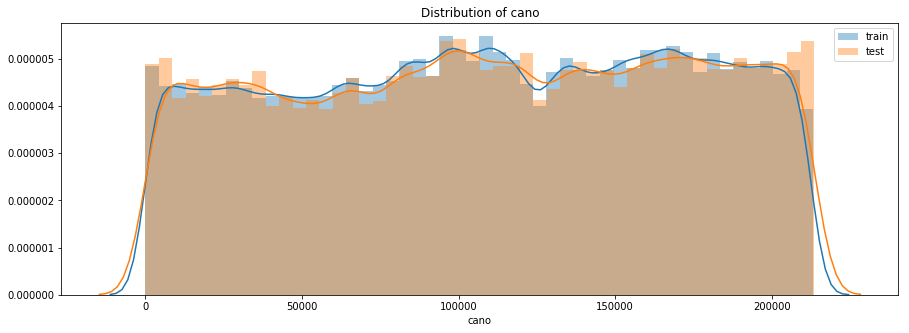

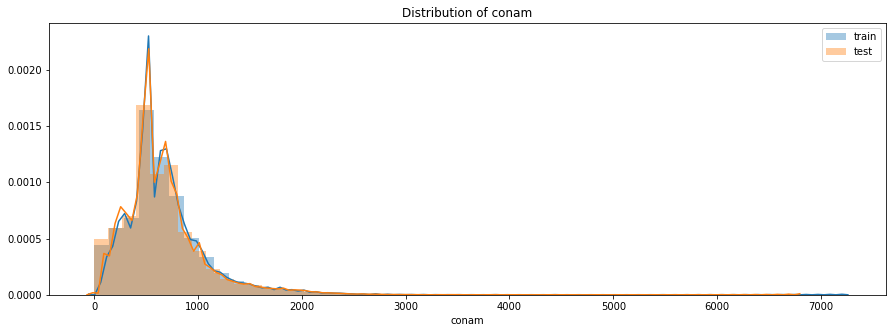

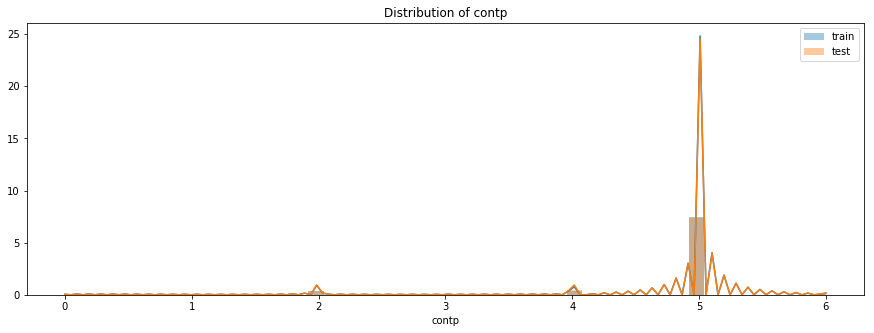

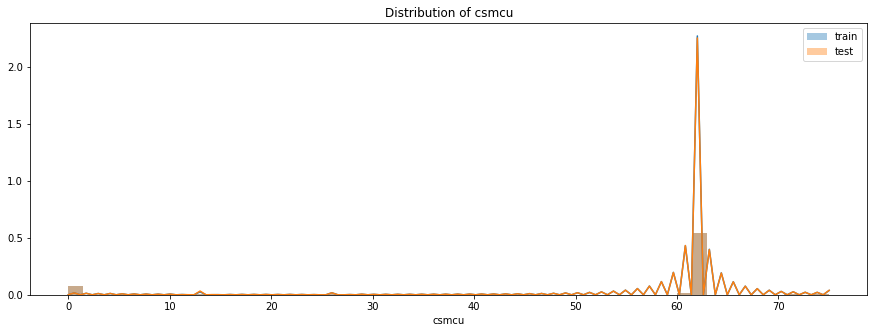

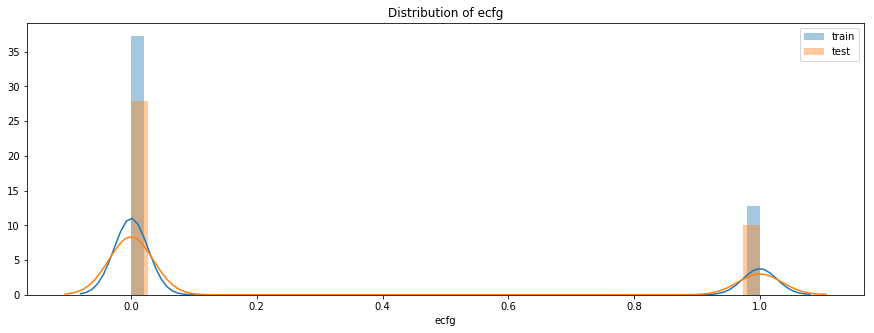

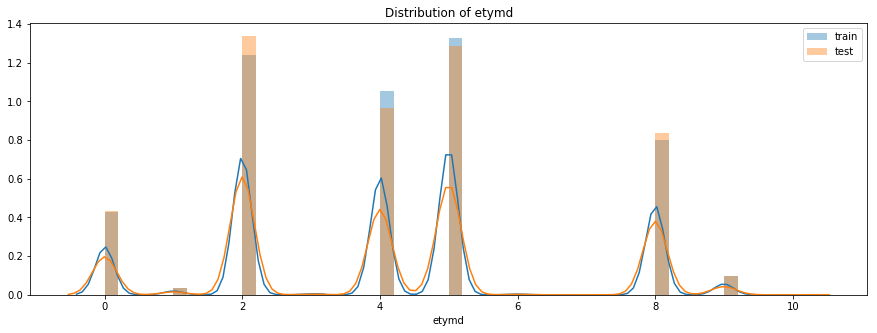

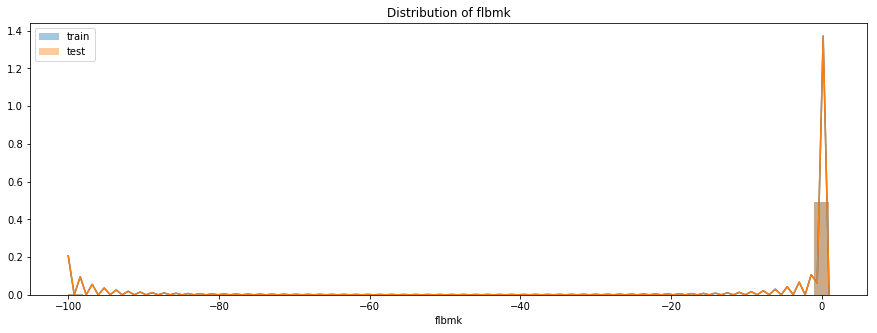

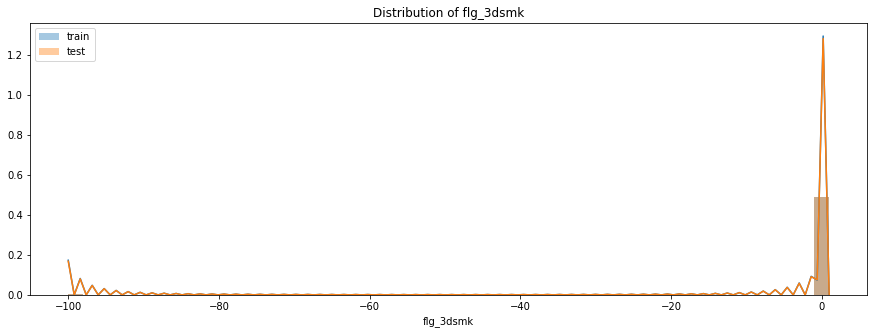

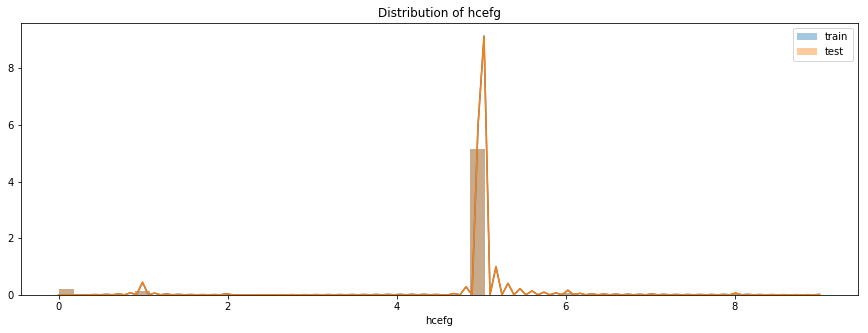

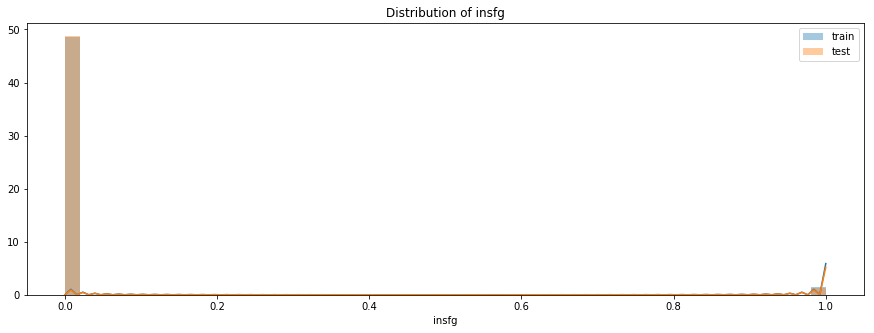

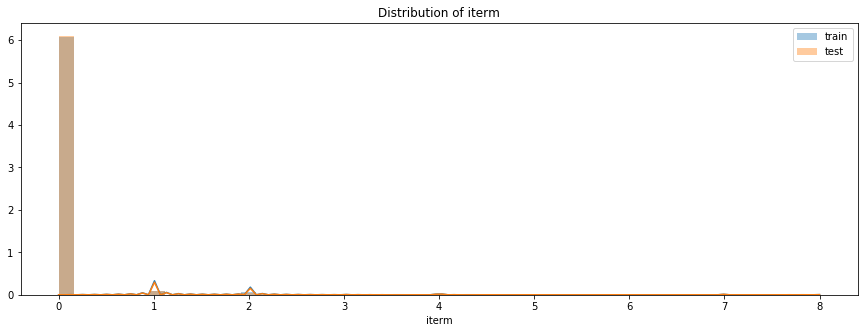

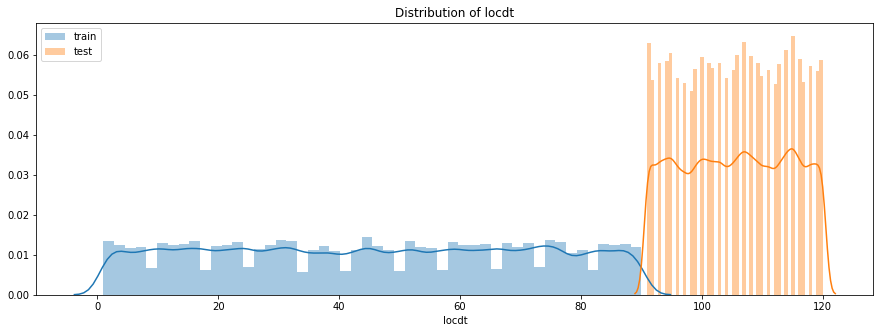

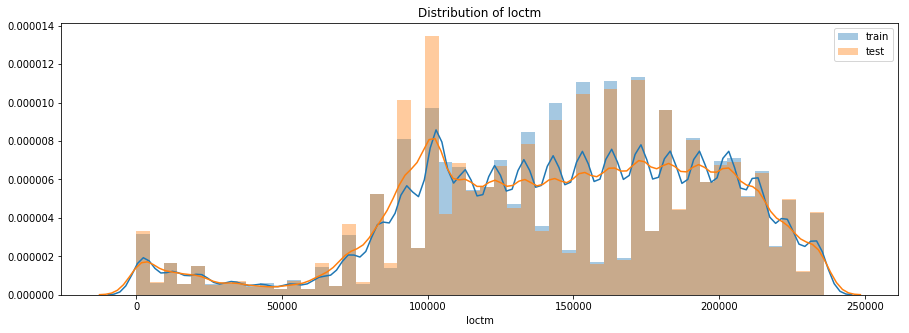

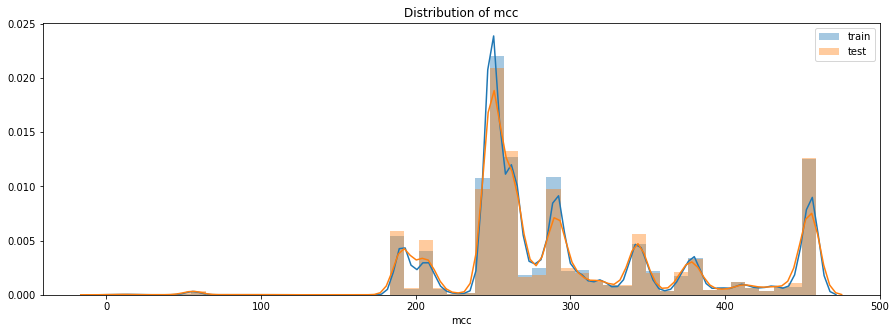

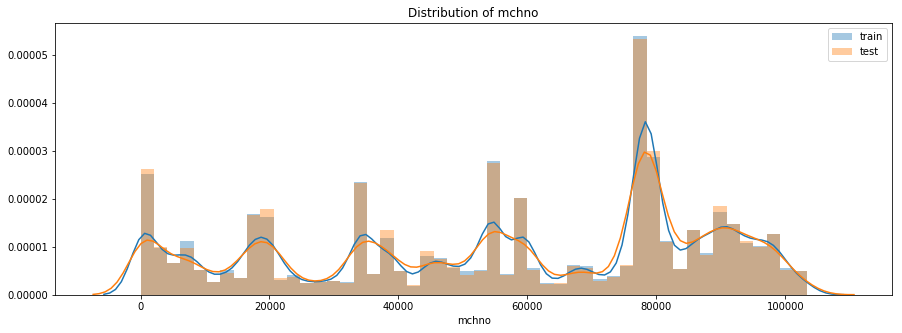

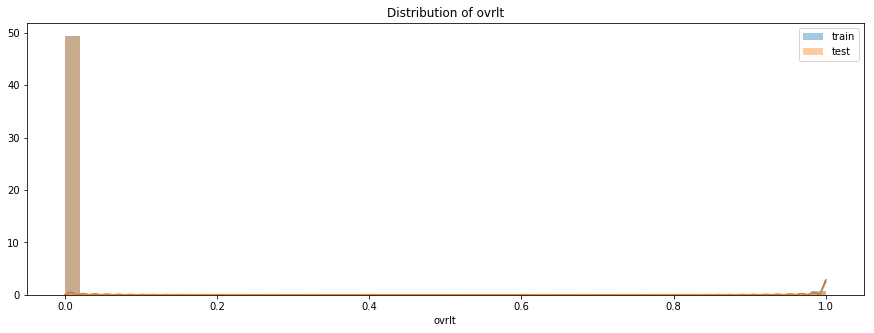

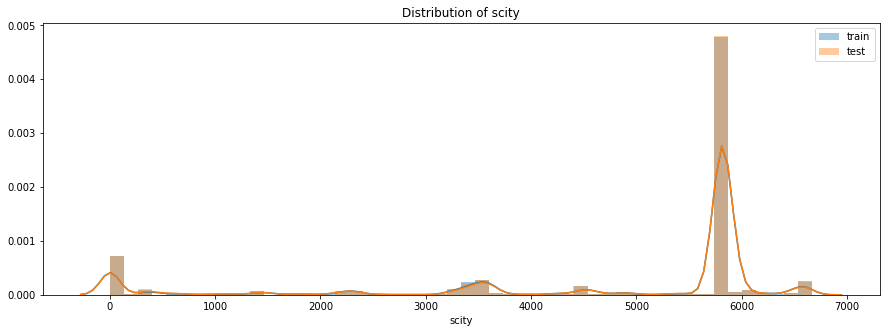

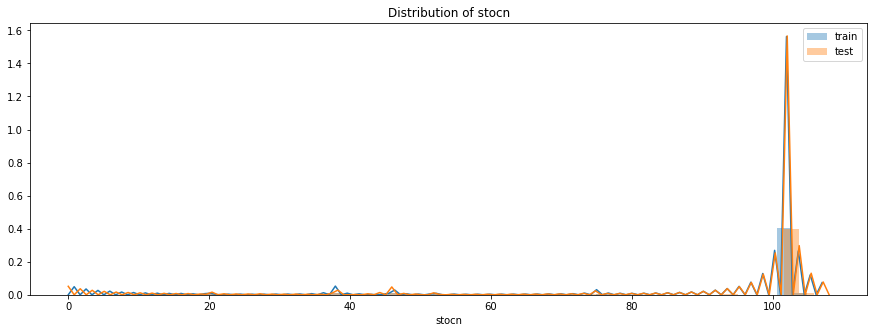

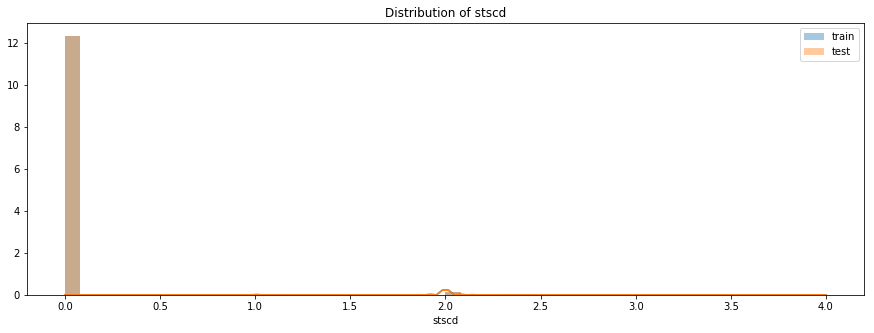

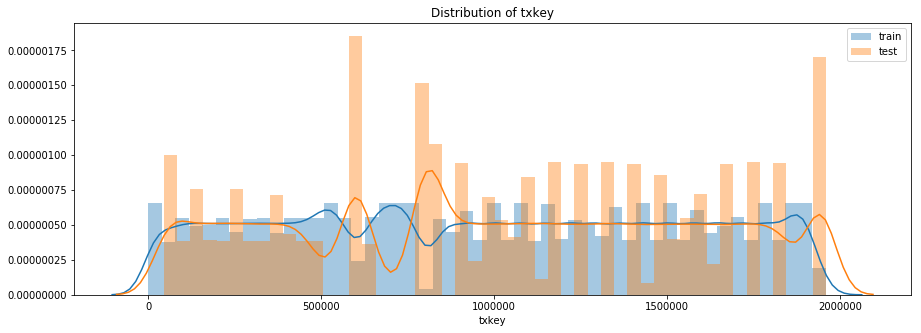

In [94]:
for i, col  in enumerate(df_test):#not use label encoding
    plt.figure(figsize=(15,5))
    sns.distplot(df[col], label='train')
    sns.distplot(df_test[col], label='test')
    plt.legend();
    plt.title('Distribution of '+col);

C:\Users\kiwi\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


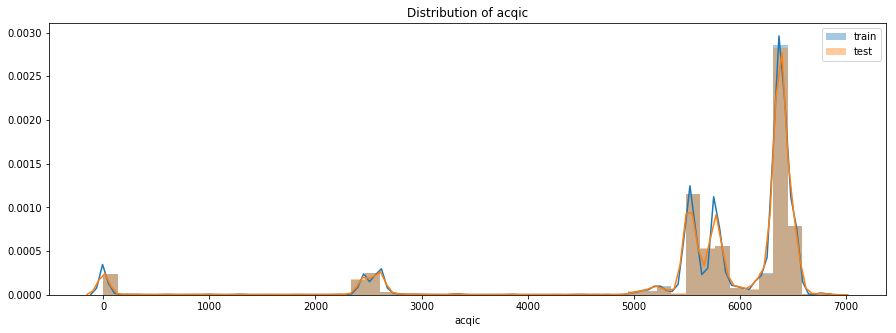

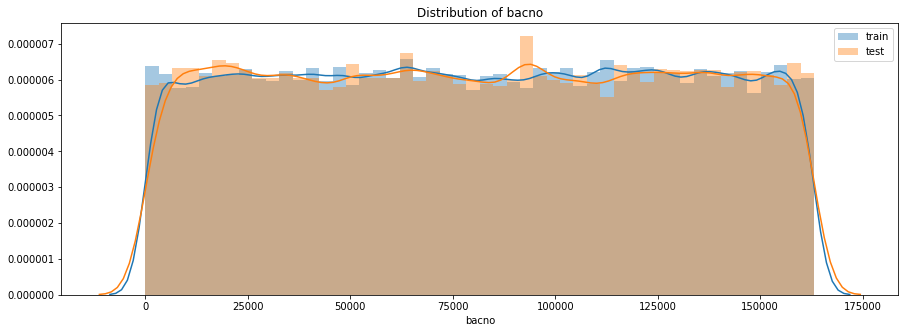

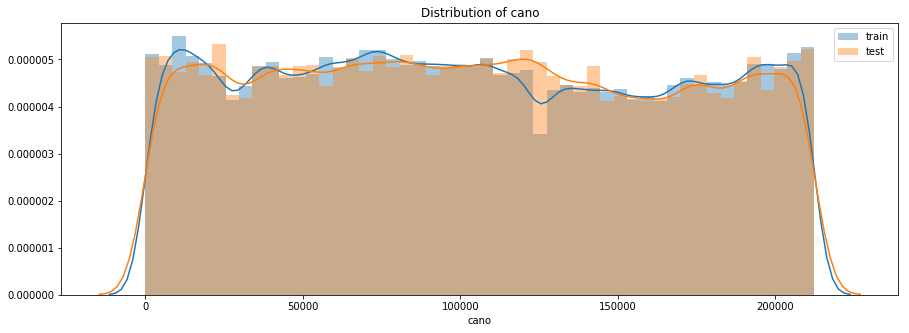

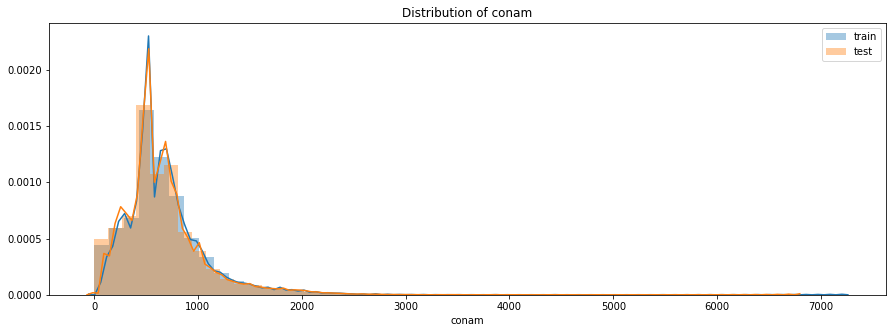

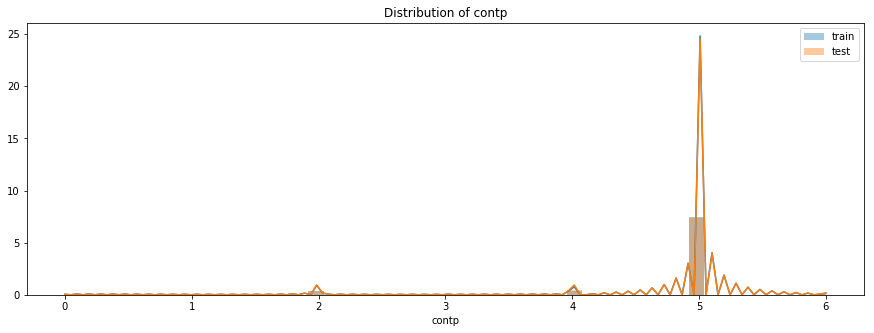

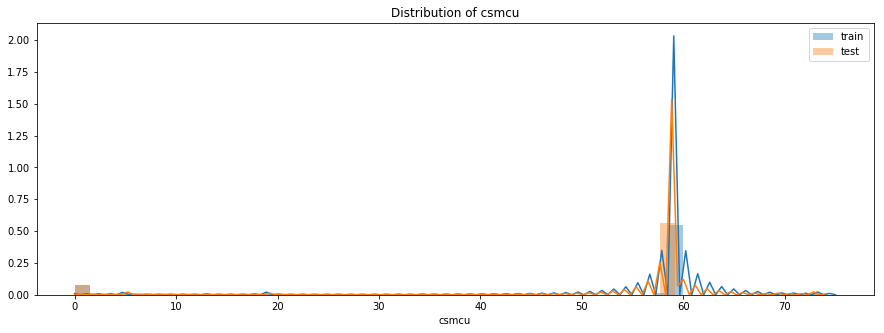

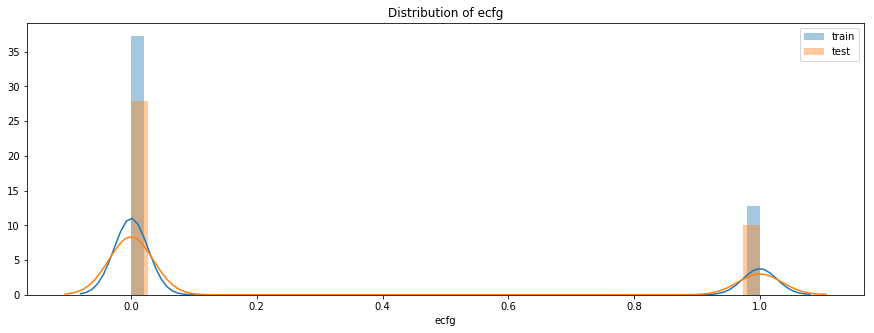

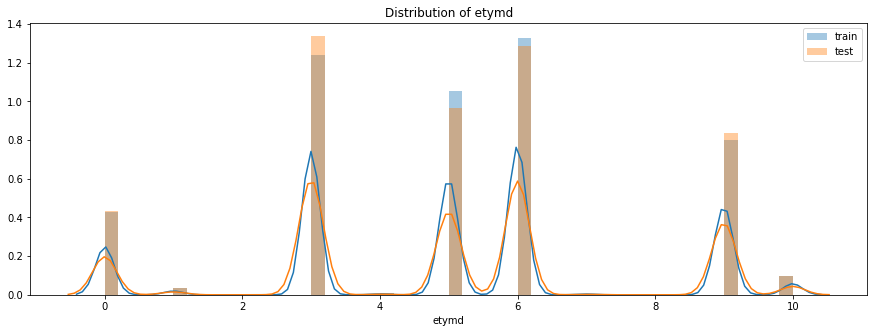

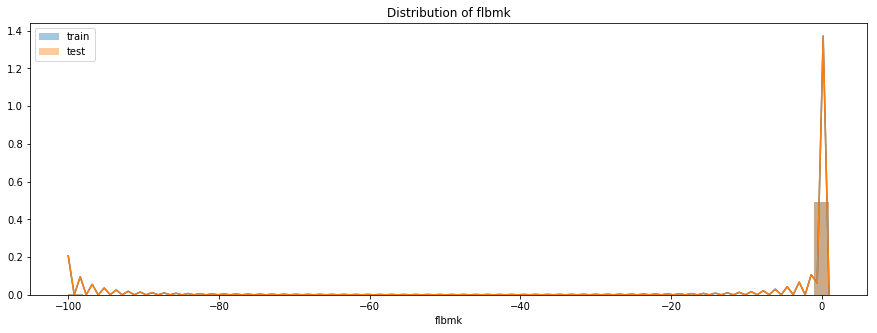

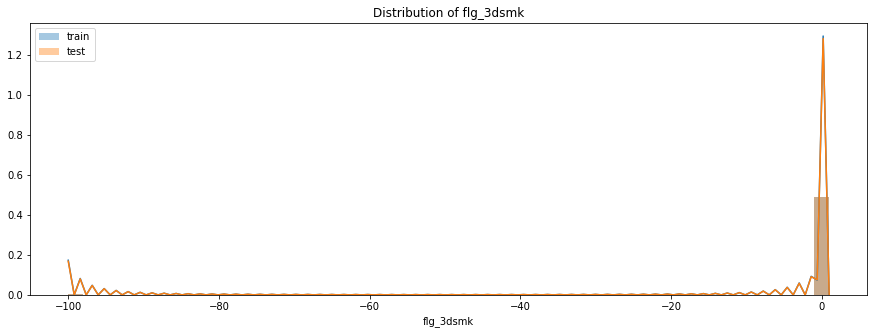

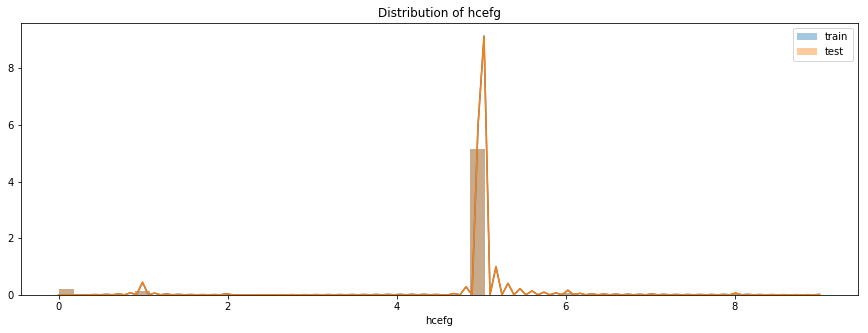

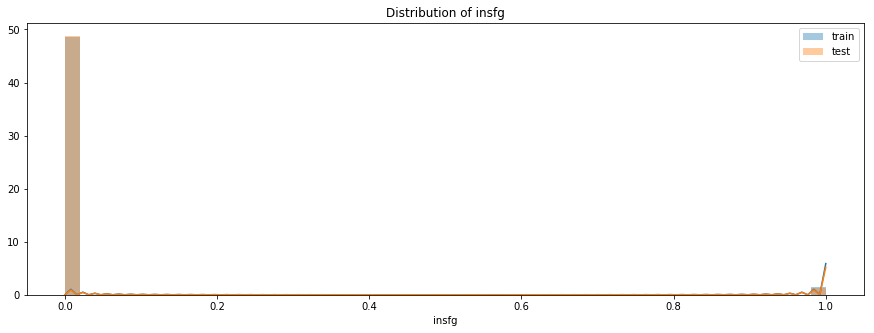

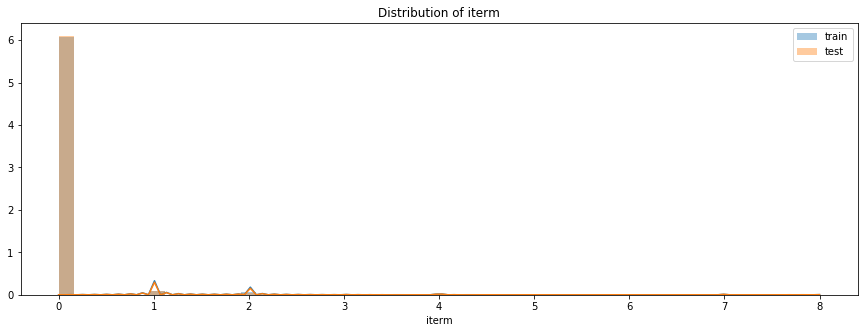

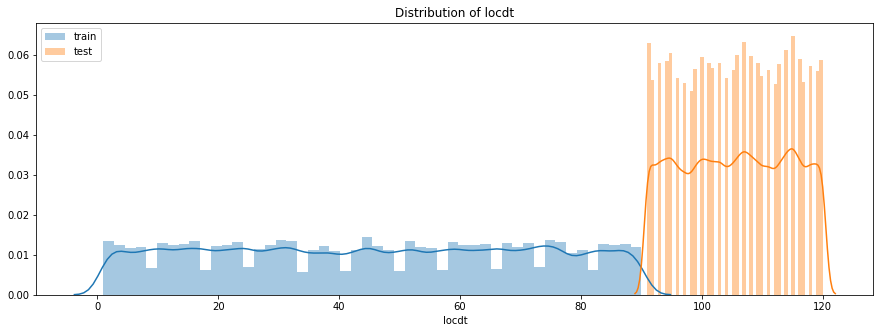

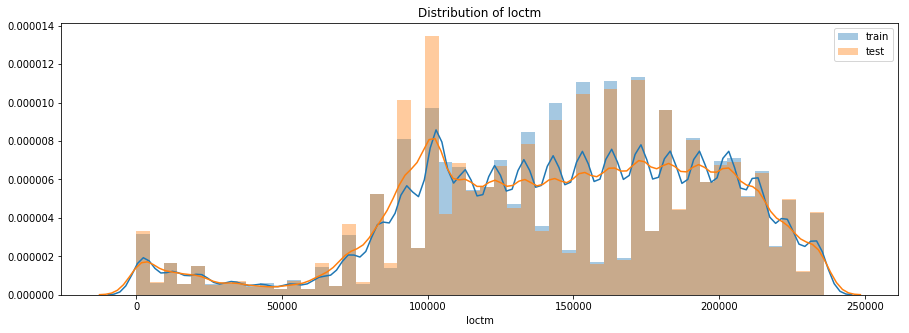

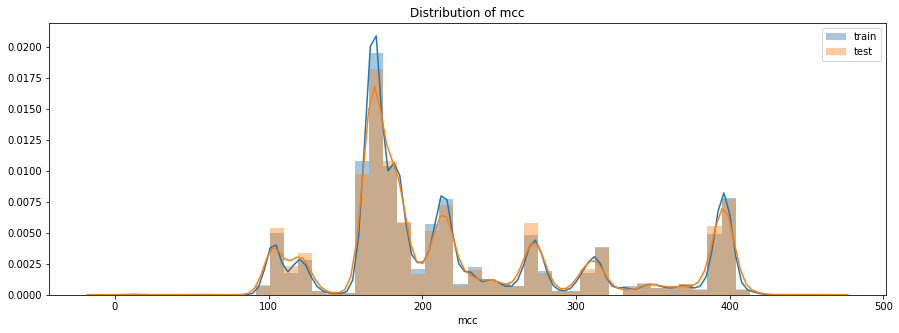

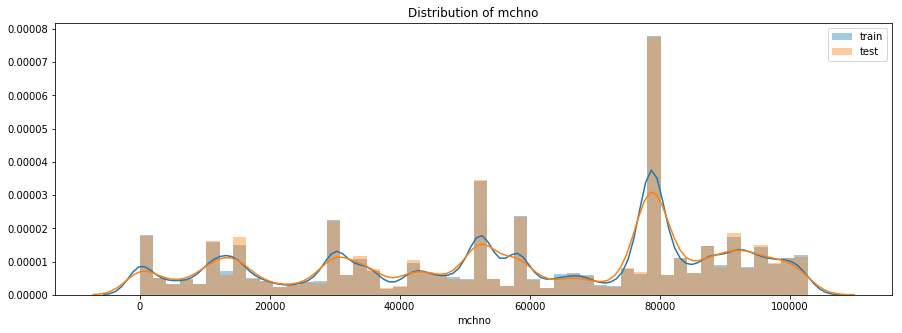

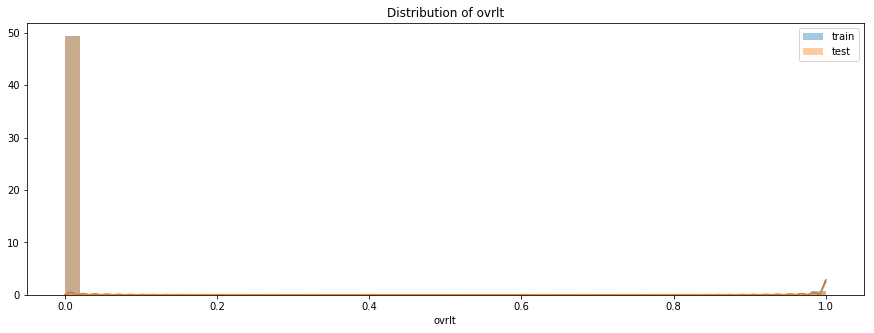

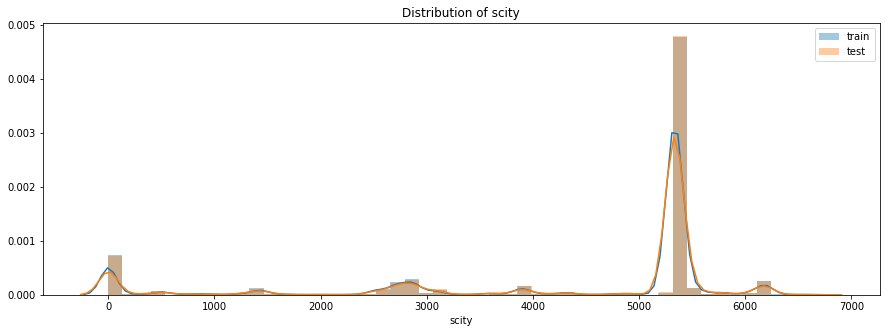

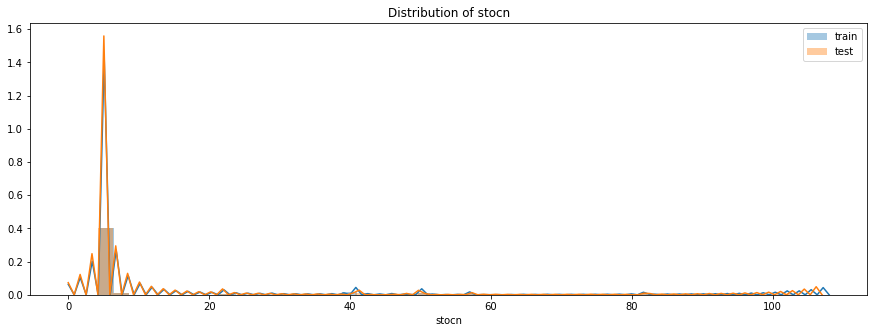

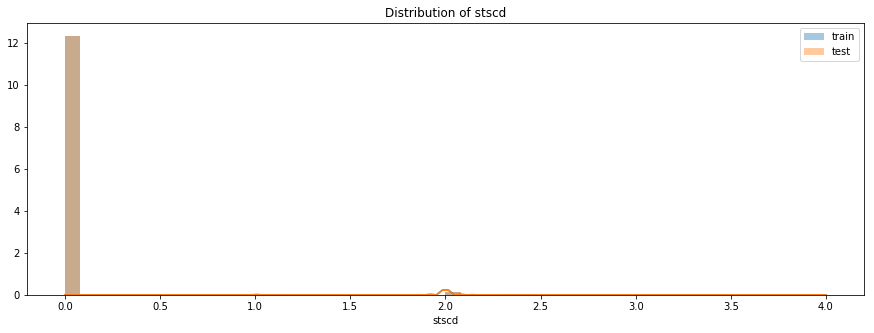

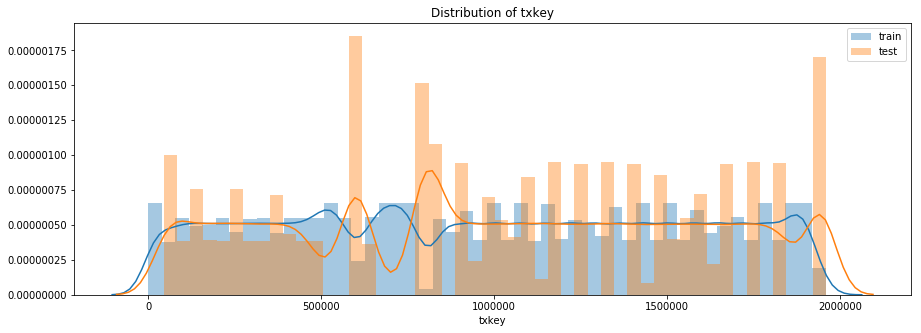

In [38]:
for i, col  in enumerate(df_test):
    plt.figure(figsize=(15,5))
    sns.distplot(df[col], label='train')
    sns.distplot(df_test[col], label='test')
    plt.legend();
    plt.title('Distribution of '+col);

In [60]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,         
          'random_state': 1337, 
          'n_jobs':-1,
          'device': 'cpu',
          #'gpu_platform_id': 1,
          #'gpu_device_id': 0,
          'seed': SEED,
         }

從這裡開始

In [61]:
df = df_backup.copy()
df_test = df_test_backup.copy()
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
print(df.shape[1])
df.columns

16


Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey'],
      dtype='object')

In [62]:
# 定义新的Y
df['Is_Test'] = 0
df_test['Is_Test'] = 1

# 将 Train 和 Test 合成一个数据集。
train_test = pd.concat([df, df_test], axis =0)


C:\Users\kiwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [63]:
    # 将样本根据时间排序
    train_test = train_test.sort_values('locdt').reset_index(drop=True)
    print(train_test['locdt'].head())
    print(len(train_test))
    train_test.columns

0    1
1    1
2    1
3    1
4    1
Name: locdt, dtype: int8
1943452


Index(['Is_Test', 'acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey'],
      dtype='object')

## 对抗验证（Adversarial Validatiion）

In [64]:
    train_test.reset_index(drop = True, inplace = True)
    train_data =  lgb.Dataset(data=train_test.drop(['Is_Test','locdt','fraud_ind','txkey'], axis=1), label=train_test.loc[:, 'Is_Test'])
    N_FOLDS = 3
    adv_cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=20000,        
        nfold=N_FOLDS,
        #categorical_feature=categorical_columns,
        early_stopping_rounds=200,
        verbose_eval=200,      
        seed=SEED)
    print('交叉验证中最优的AUC为 {:.5f}，对应的标准差为{:.5f}.'.format(
    adv_cv_results['auc-mean'][-1], adv_cv_results['auc-stdv'][-1]))
    print('模型最优的迭代次数为{}.'.format(len(adv_cv_results['auc-mean'])))  
   

[200]	cv_agg's auc: 0.760321 + 0.00292525
[400]	cv_agg's auc: 0.788258 + 0.0016718
[600]	cv_agg's auc: 0.801223 + 0.00183957
[800]	cv_agg's auc: 0.809274 + 0.00194025
[1000]	cv_agg's auc: 0.815948 + 0.00174881
[1200]	cv_agg's auc: 0.821138 + 0.00148947
[1400]	cv_agg's auc: 0.825575 + 0.00149026
[1600]	cv_agg's auc: 0.829842 + 0.0020844
[1800]	cv_agg's auc: 0.832149 + 0.00153613
[2000]	cv_agg's auc: 0.83408 + 0.00161339
[2200]	cv_agg's auc: 0.835944 + 0.00160534
[2400]	cv_agg's auc: 0.837407 + 0.00192597
[2600]	cv_agg's auc: 0.839112 + 0.00170985
[2800]	cv_agg's auc: 0.841297 + 0.00174612
[3000]	cv_agg's auc: 0.84285 + 0.00114643
[3200]	cv_agg's auc: 0.84351 + 0.00117345
[3400]	cv_agg's auc: 0.844309 + 0.00110282
[3600]	cv_agg's auc: 0.845112 + 0.00114638
[3800]	cv_agg's auc: 0.845415 + 0.00114726
[4000]	cv_agg's auc: 0.846044 + 0.00104816
[4200]	cv_agg's auc: 0.847053 + 0.000999431
[4400]	cv_agg's auc: 0.847498 + 0.00102902
[4600]	cv_agg's auc: 0.848314 + 0.00116437
[4800]	cv_agg's auc

In [65]:
params['n_estimators'] = len(adv_cv_results['auc-mean'])
params

{'num_leaves': 499,
 'min_child_weight': 0.009009297771374483,
 'feature_fraction': 0.8931730501715401,
 'bagging_fraction': 0.8249551970384116,
 'min_data_in_leaf': 120,
 'objective': 'binary',
 'max_depth': -1,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt',
 'bagging_seed': 11,
 'metric': 'auc',
 'verbosity': -1,
 'reg_alpha': 1.1690935357787136,
 'reg_lambda': 1.119698800271026,
 'random_state': 1337,
 'n_jobs': -1,
 'device': 'cpu',
 'seed': 42,
 'n_estimators': 11798}

In [66]:
params['n_estimators'] = len(adv_cv_results['auc-mean'])

model_adv = lgb.LGBMClassifier(**params)
model_adv.fit(train_test.drop(['Is_Test','locdt','fraud_ind','txkey'], axis=1), train_test.loc[:, 'Is_Test'])

preds_adv = model_adv.predict_proba(train_test.drop(['Is_Test','locdt','fraud_ind','txkey'], axis=1))[:, 1]

In [68]:
# 提取出训练集上，样本是测试集的概率
df_copy = df.copy()
df_copy['is_test_prob'] = preds_adv[:len(df)]

# 根据概率排序
df_copy = df_copy.sort_values('is_test_prob').reset_index(drop=True)
df_copy[['is_test_prob','txkey','Is_Test']].tail(10)

,is_test_prob,txkey,Is_Test
1521777,0.882414,344376,0
1521778,0.885262,400627,0
1521779,0.885318,121614,0
1521780,0.885318,1358385,0
1521781,0.887009,1631625,0
1521782,0.896910,492945,0
1521783,0.908377,620352,0
1521784,0.931225,1486655,0
1521785,0.931225,249925,0
1521786,0.935114,841731,0


In [70]:
df_copy.shape
df_copy.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'Is_Test', 'is_test_prob'],
      dtype='object')

In [71]:
#輸出新訓練集案概率排序
df_copy_new=df_copy.copy()
df_copy_new.drop('is_test_prob', axis=1, inplace=True)
df_copy_new.drop('Is_Test', axis=1, inplace=True)
print(df_copy_new.columns,df_copy_new.shape)
df_copy_new.to_csv('df_sortprob_16.csv',index = None)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey'],
      dtype='object') (1521787, 16)


In [72]:
# 将概率最大的20%作为验证集
df_validation_2 = df_copy.iloc[int(0.8 * len(df)):, ]
df_train_2 = df_copy.iloc[:int(0.8 * len(df)), ]

df_validation_2.drop('is_test_prob', axis=1, inplace=True)
df_train_2.drop('is_test_prob', axis=1, inplace=True)
print(len(df_validation_2))
print(len(df_train_2))

304358
1217429


C:\Users\kiwi\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [73]:
def run_lgb(df_train, df_validation):
    dtrain = lgb.Dataset(
        data=df_train.drop('fraud_ind', axis=1),
        label=df_train.loc[:, 'fraud_ind'],
        free_raw_data=False,
        silent=True)

    dvalid = lgb.Dataset(
        data=df_validation.drop('fraud_ind', axis=1),
        label=df_validation.loc[:, 'fraud_ind'],
        free_raw_data=False,
        silent=True)

    params.pop('n_estimators', None)

    clf = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dvalid],
        early_stopping_rounds=200,
        verbose_eval=50
      )

    params['n_estimators'] = clf.num_trees()

    model = lgb.LGBMClassifier(**params)
    model.fit(
        df_train.drop('fraud_ind', axis=1),
        df_train.loc[:, 'fraud_ind'])

    # AUC
    preds_test = model.predict_proba(
        df_validation.drop('fraud_ind', axis=1))[:, 1]
    auc_test = roc_auc_score(df_validation.loc[:, 'fraud_ind'], preds_test)
    print('模型在驗證集上的效果是{:.5f}。'.format(
        roc_auc_score(df_validation.loc[:, 'fraud_ind'], preds_test)))
    return model

In [74]:
model_2 = run_lgb(df_train_2, df_validation_2)

Training until validation scores don't improve for 200 rounds.
[50]	training's auc: 0.995683	valid_1's auc: 0.987555
[100]	training's auc: 0.998968	valid_1's auc: 0.9897
[150]	training's auc: 0.999698	valid_1's auc: 0.990286
[200]	training's auc: 0.999899	valid_1's auc: 0.99061
[250]	training's auc: 0.999962	valid_1's auc: 0.990723
[300]	training's auc: 0.999985	valid_1's auc: 0.990713
[350]	training's auc: 0.999993	valid_1's auc: 0.990665
[400]	training's auc: 0.999996	valid_1's auc: 0.990596
[450]	training's auc: 0.999998	valid_1's auc: 0.990594
Early stopping, best iteration is:
[274]	training's auc: 0.999976	valid_1's auc: 0.990745
模型在驗證集上的效果是0.99075。


In [ ]:
#0.000003

In [65]:
print(df_train_2.columns,df_train_2.shape)
print(df_validation_2.columns,df_validation_2.shape)
print(df_train_2['Is_Test'].value_counts())
df_validation_2['Is_Test'].value_counts()

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'txkey', 'Is_Test'],
      dtype='object') (1217429, 16)
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'txkey', 'Is_Test'],
      dtype='object') (304358, 16)
0    1217429
Name: Is_Test, dtype: int64


0    304358
Name: Is_Test, dtype: int64

In [66]:
df_train_2 = df_train_2.drop( ['Is_Test'], axis = 1 )
df_validation_2 = df_validation_2.drop( ['Is_Test'], axis = 1 )

In [67]:
print(df_train_2['fraud_ind'].value_counts())
print(df_validation_2['fraud_ind'].value_counts())
print(df_train_2.columns)
print(df_train_2.shape)
print(df_validation_2.columns)
print(df_validation_2.shape)

0    1201088
1      16341
Name: fraud_ind, dtype: int64
0    300344
1      4014
Name: fraud_ind, dtype: int64
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'txkey'],
      dtype='object')
(1217429, 15)
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'txkey'],
      dtype='object')
(304358, 15)


C:\Users\kiwi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kiwi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


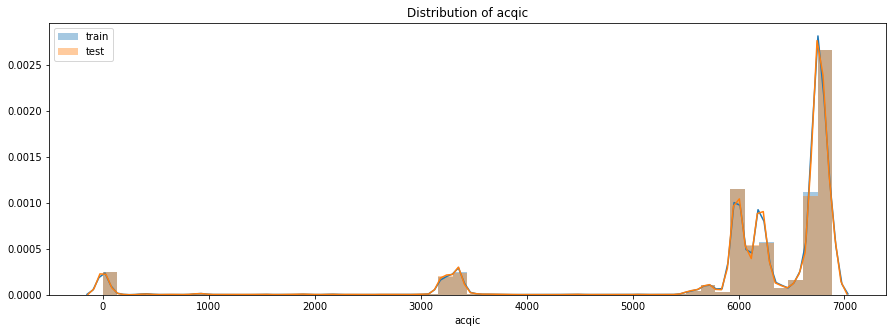

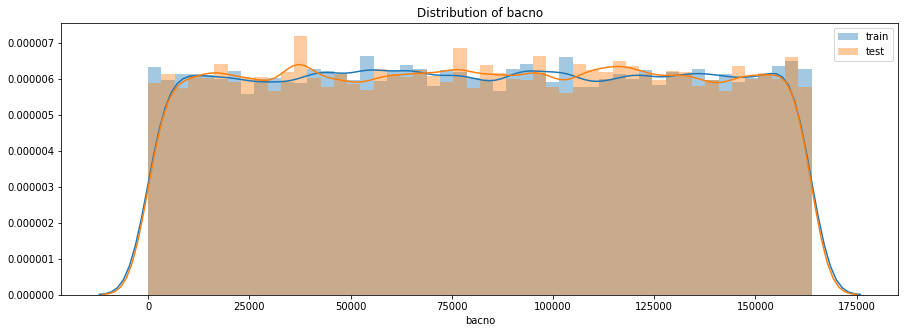

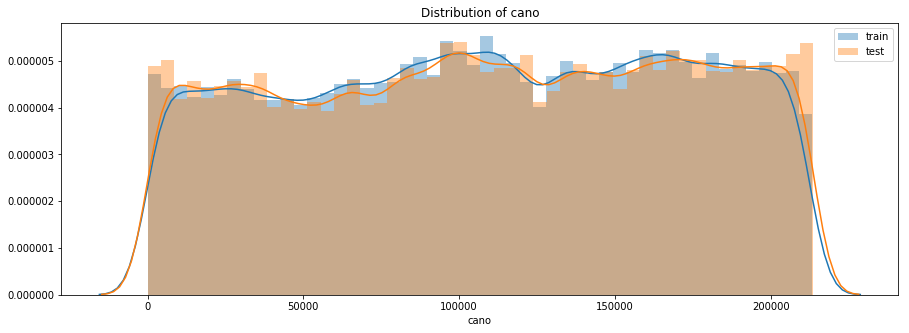

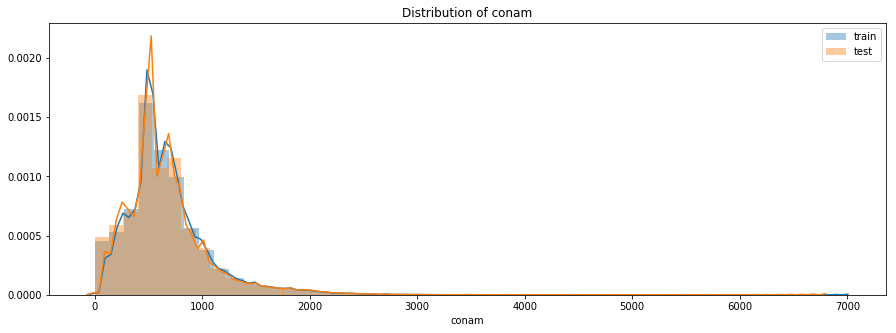

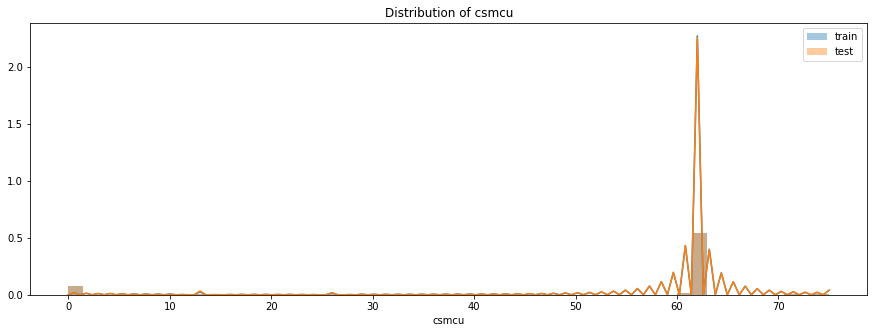

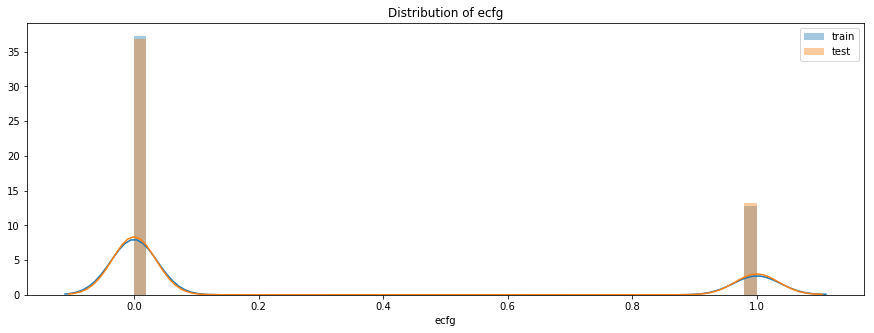

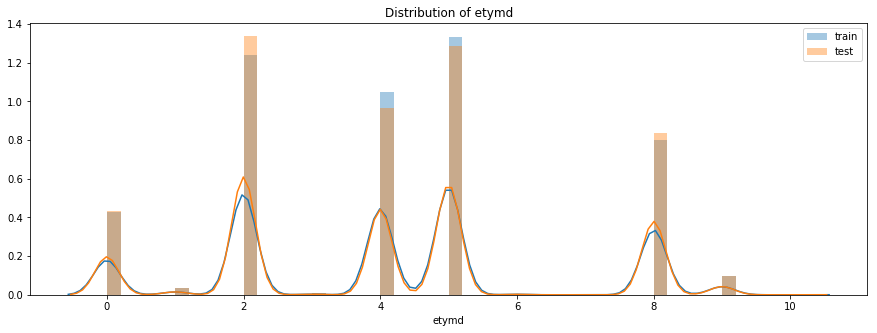

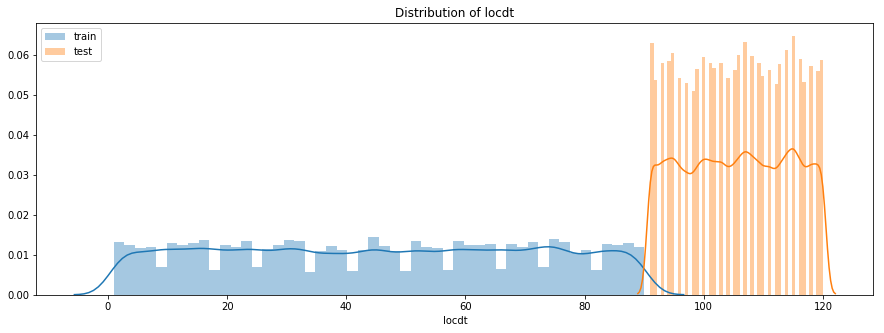

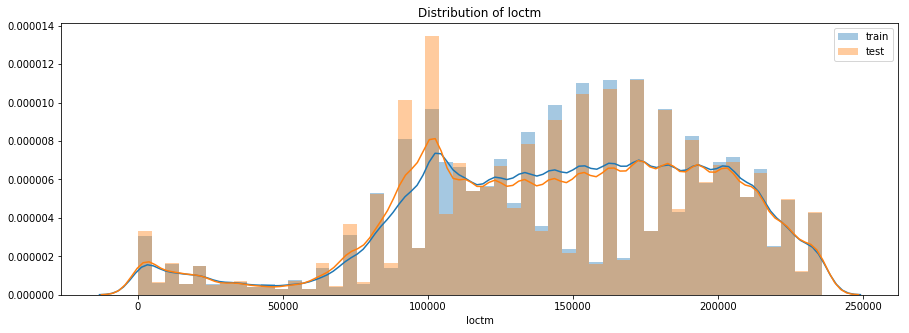

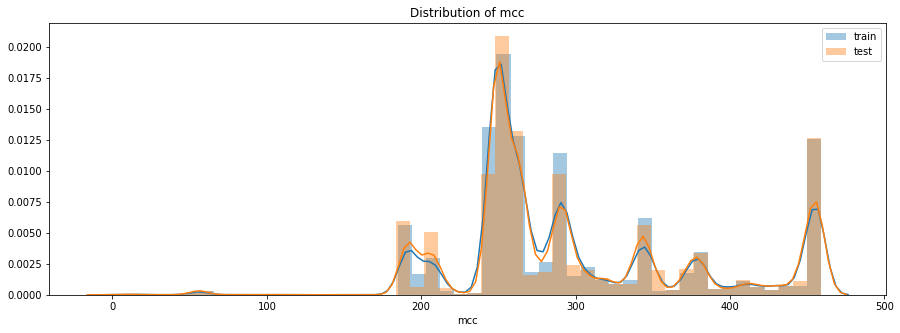

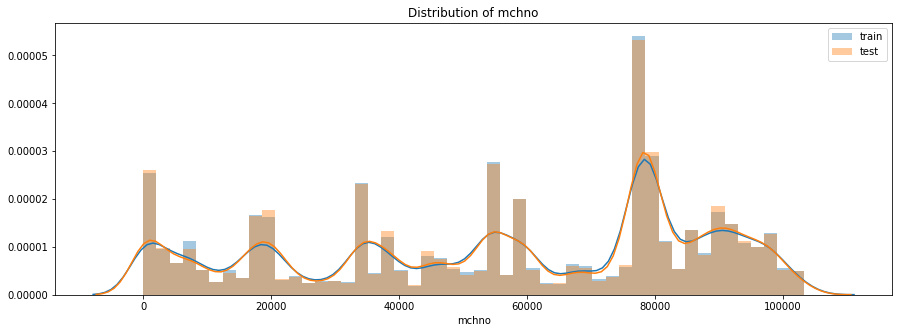

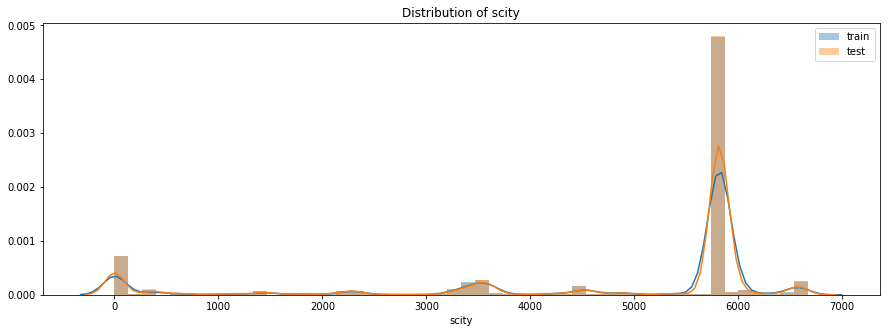

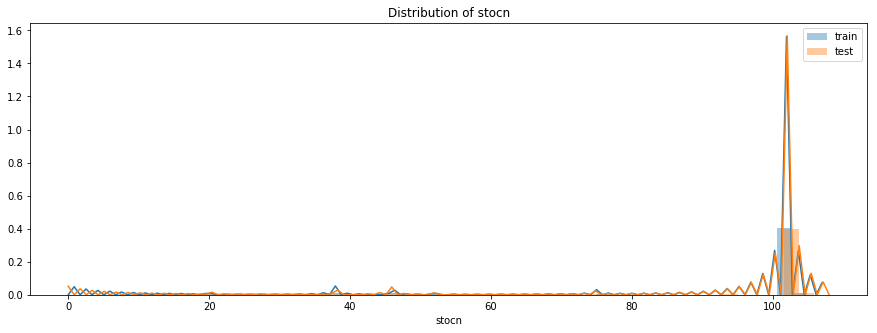

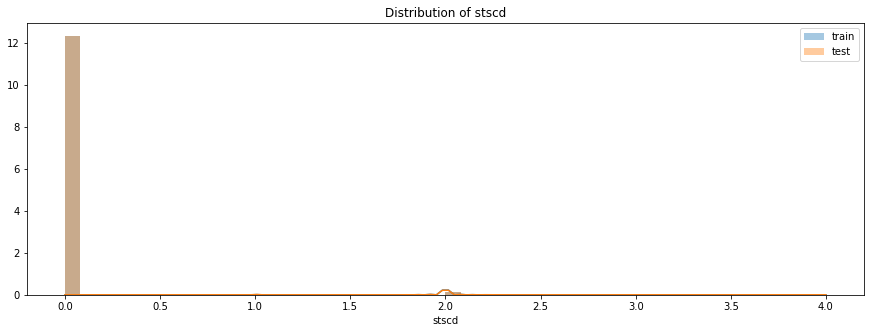

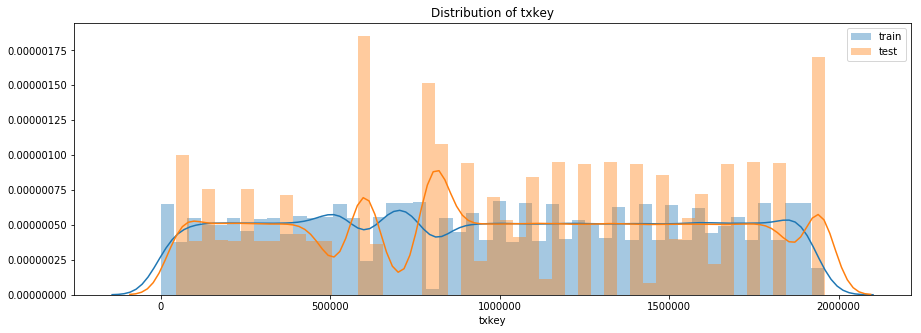

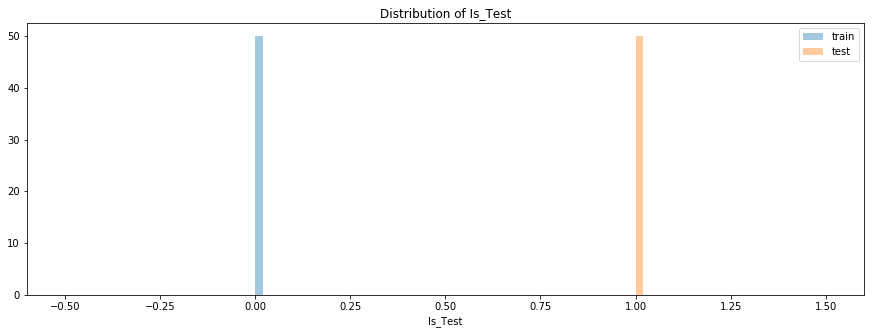

In [75]:
#新 16沒做label encoding
df_show = df_validation_2.drop( ['fraud_ind'], axis = 1 )
for i, col  in enumerate(df_show.columns):
    plt.figure(figsize=(15,5))
    sns.distplot(df_validation_2[col], label='train',bins=50);
    sns.distplot(df_test[col], label='test',bins=50);    
    plt.legend();
    plt.title('Distribution of '+col);

C:\Users\kiwi\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


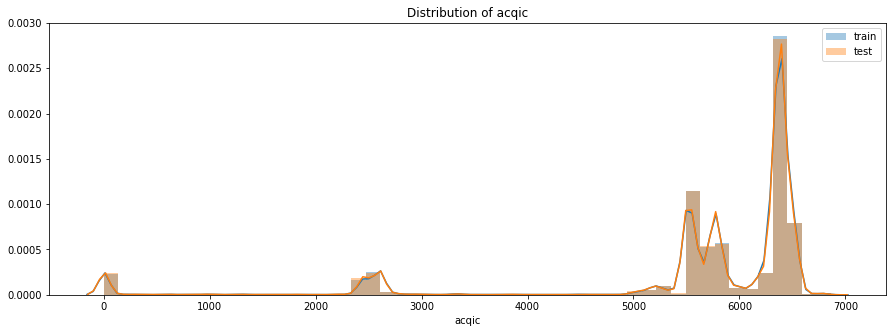

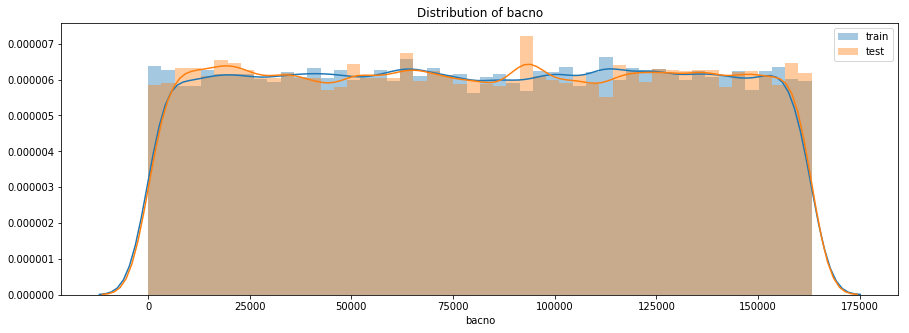

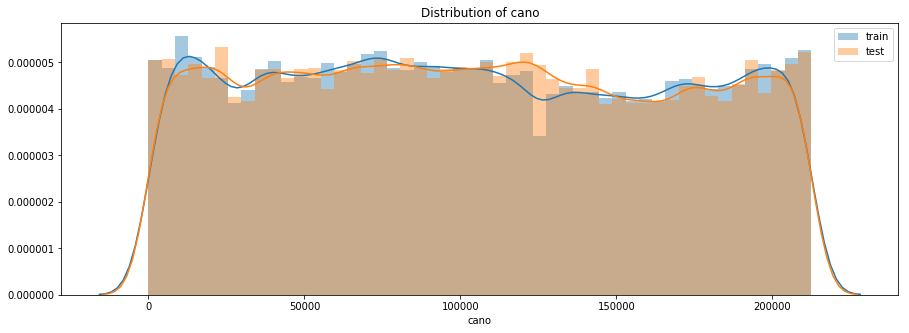

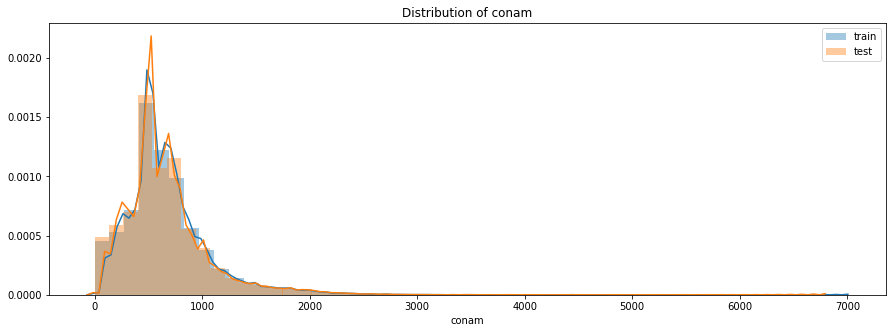

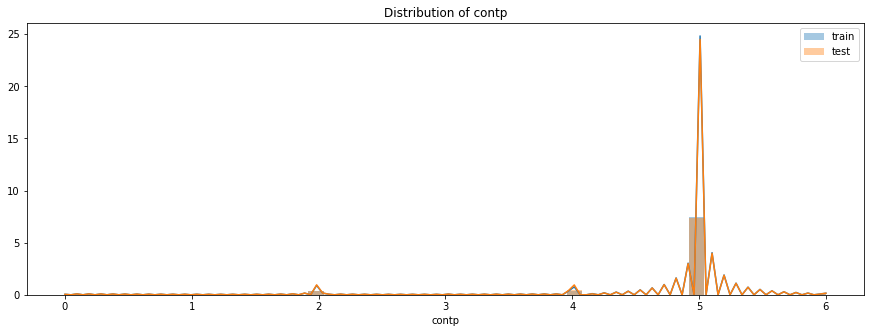

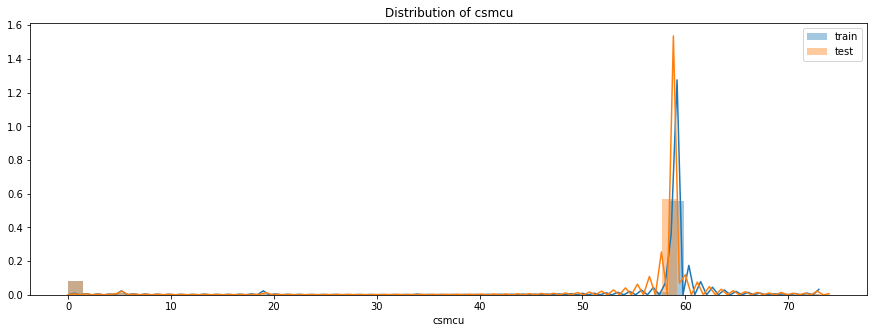

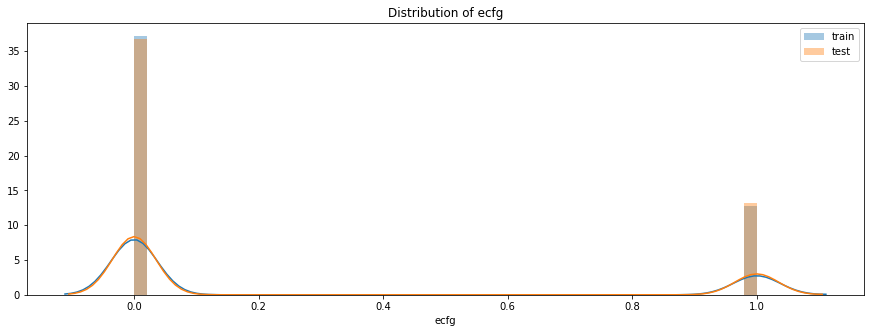

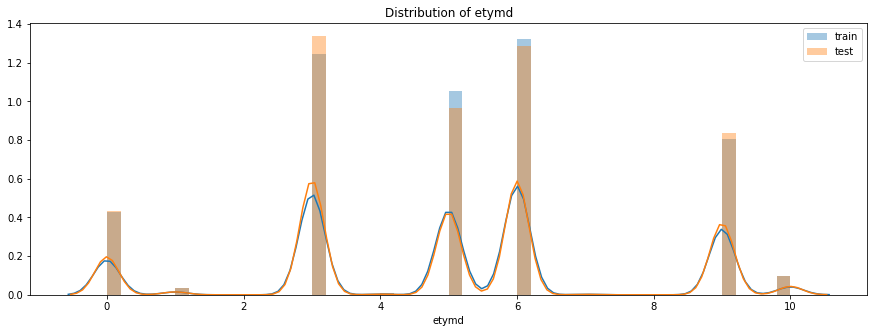

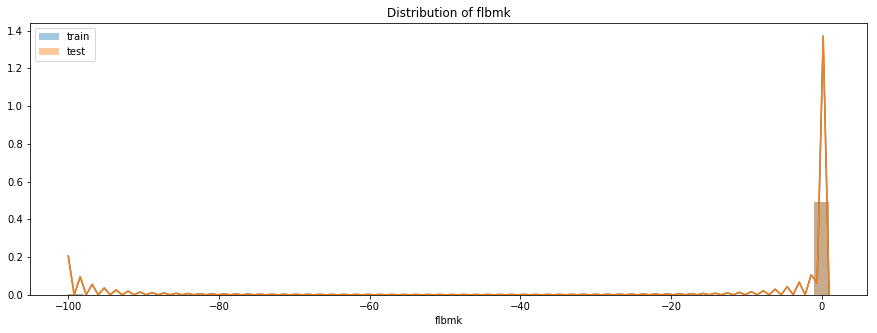

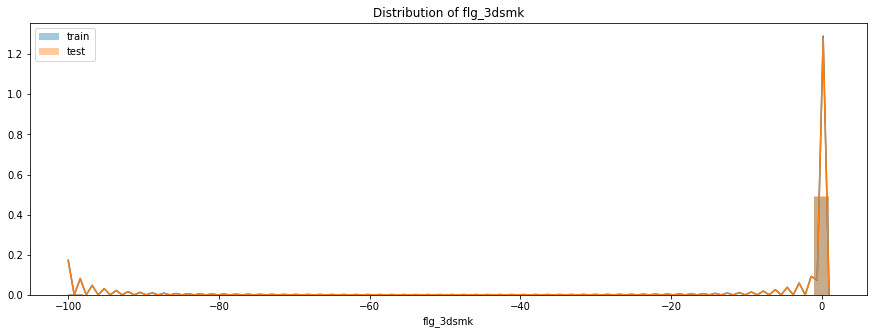

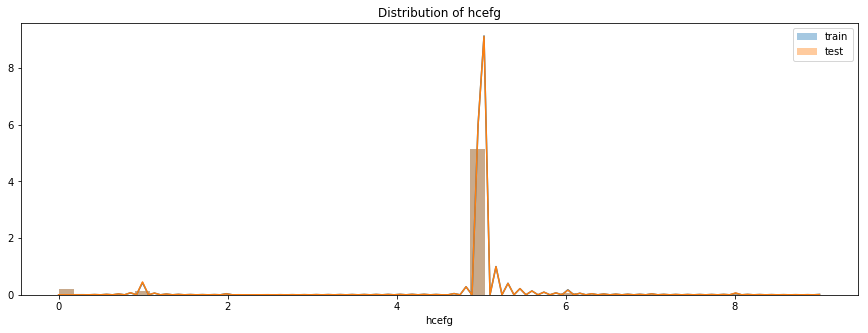

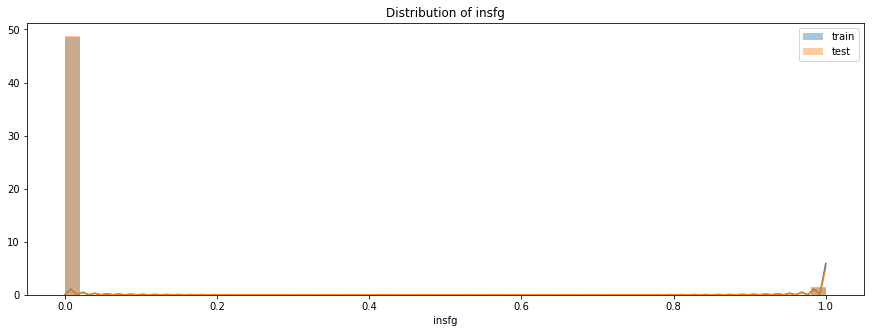

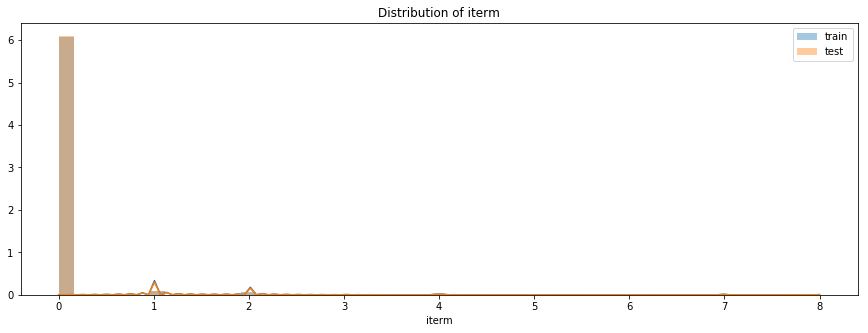

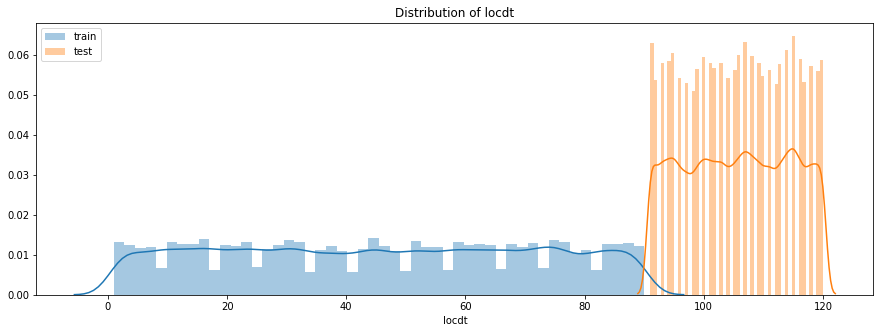

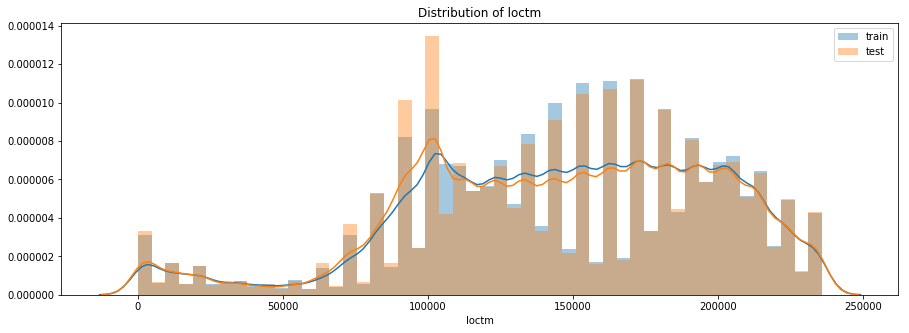

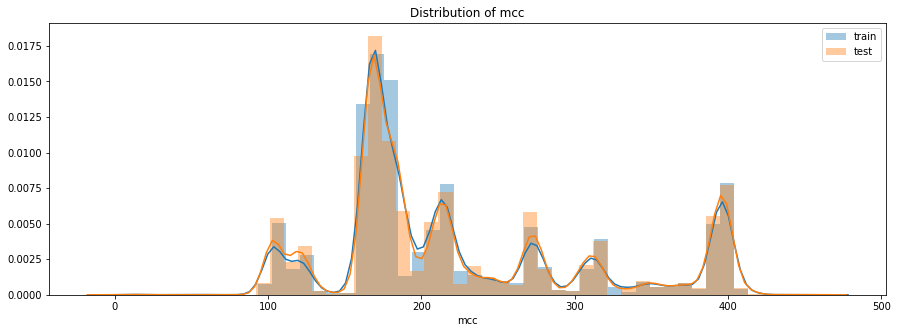

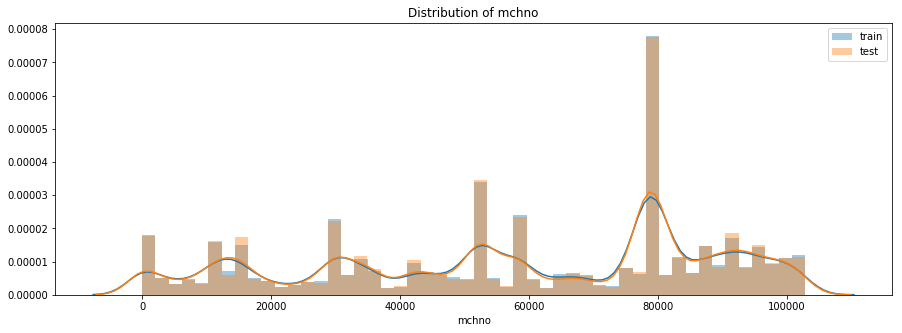

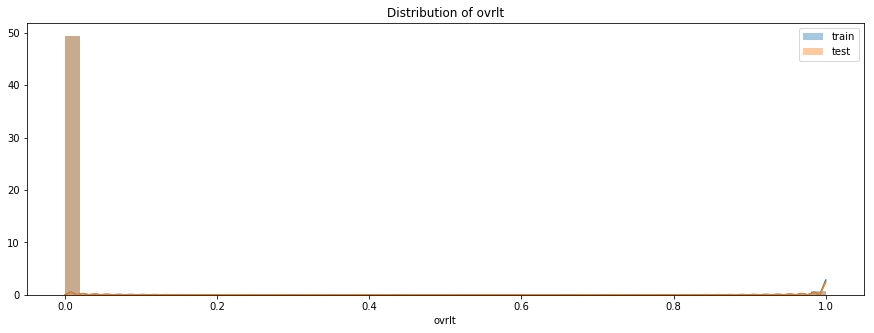

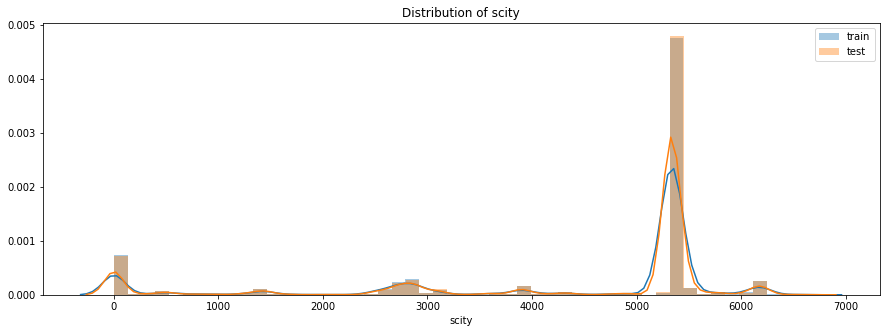

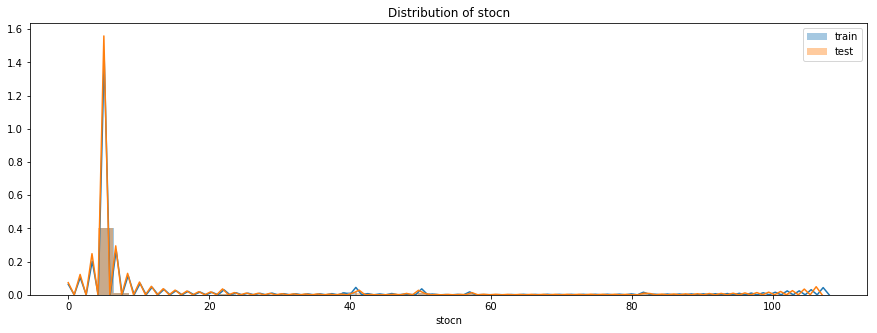

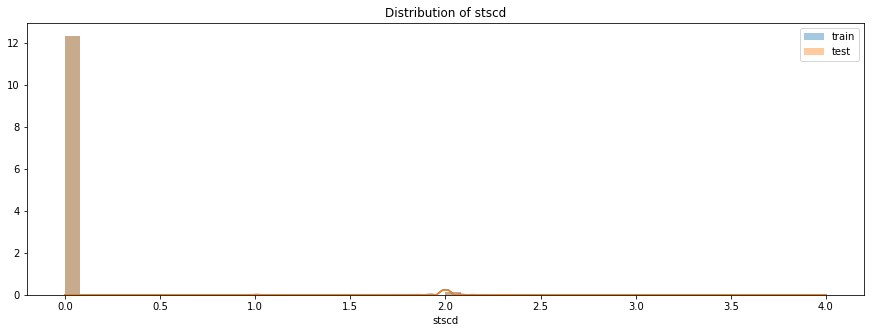

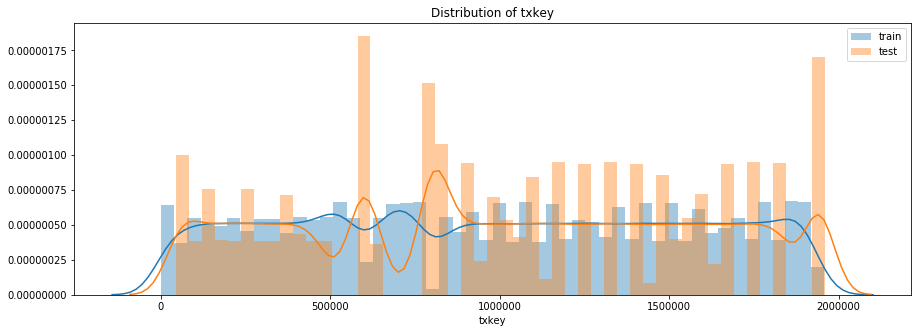

In [76]:
#顯示分布
df_show = df_validation_2.drop( ['fraud_ind'], axis = 1 )
for i, col  in enumerate(df_show.columns):
    plt.figure(figsize=(15,5))
    sns.distplot(df_validation_2[col], label='train',bins=50);
    sns.distplot(df_test[col], label='test',bins=50);    
    plt.legend();
    plt.title('Distribution of '+col);

C:\Users\kiwi\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


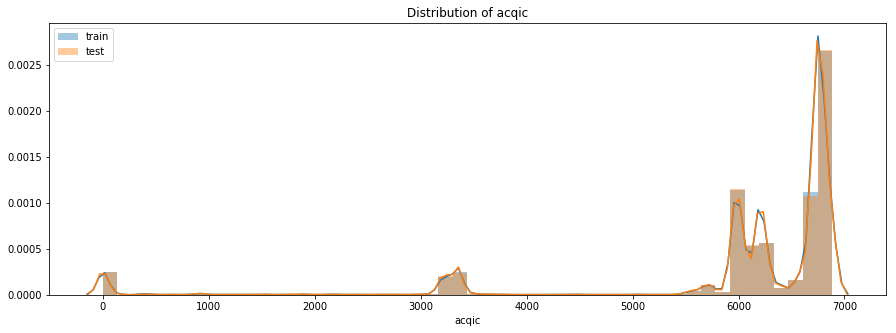

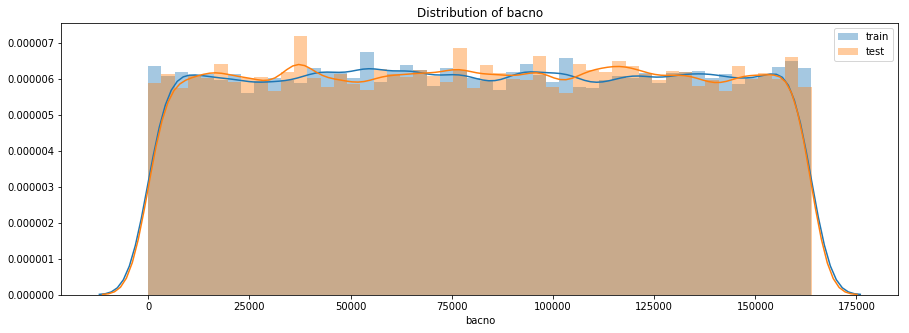

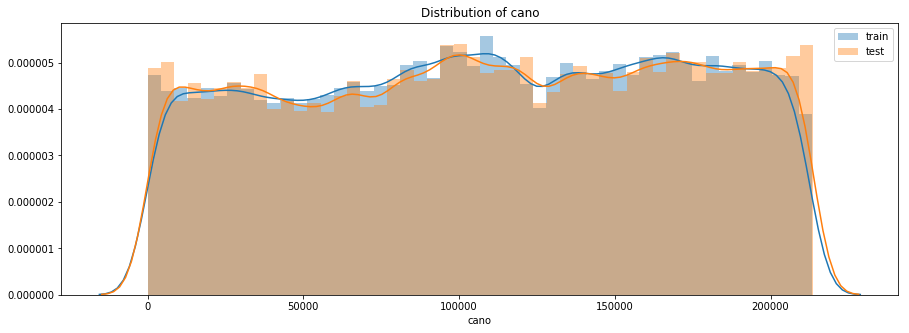

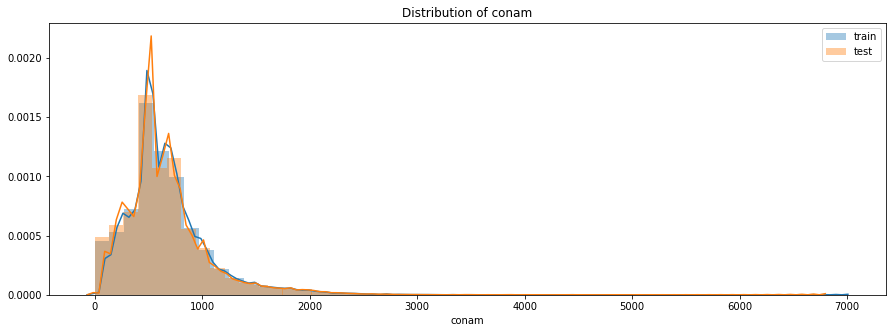

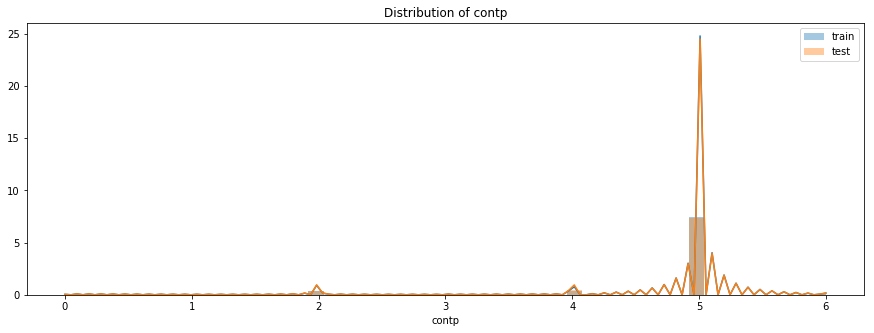

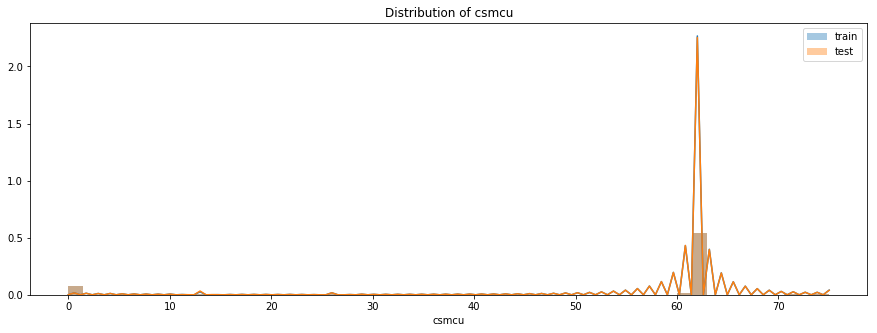

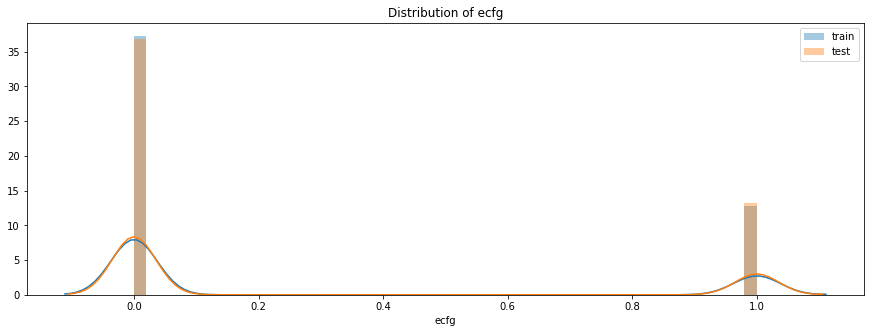

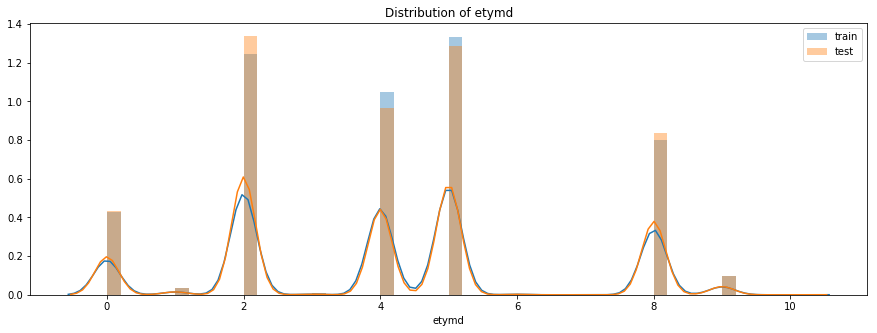

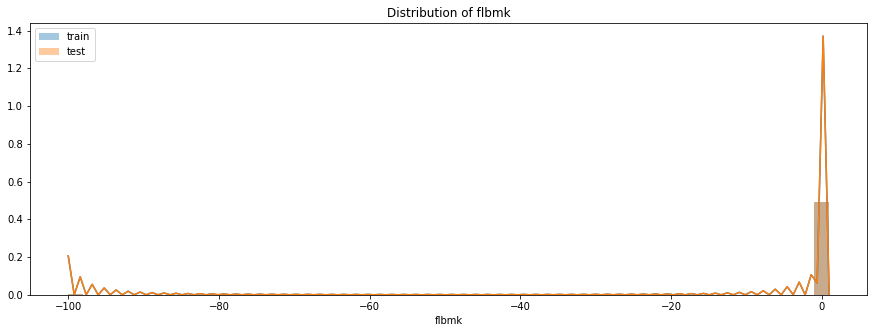

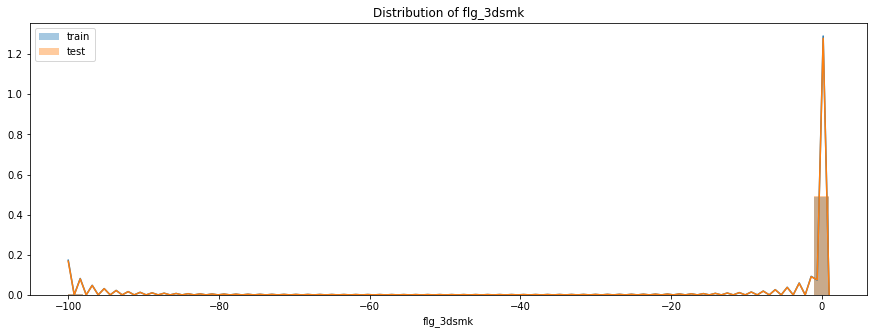

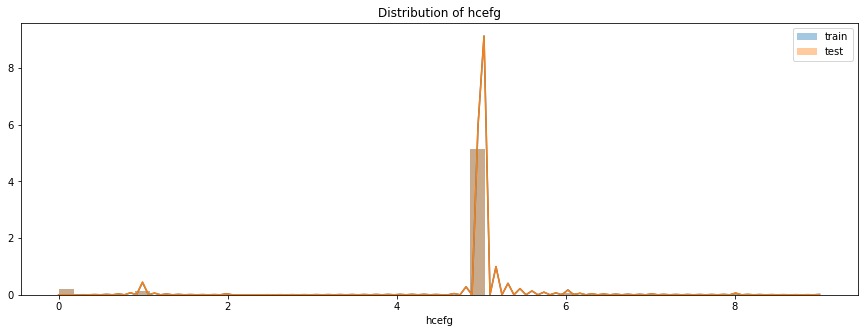

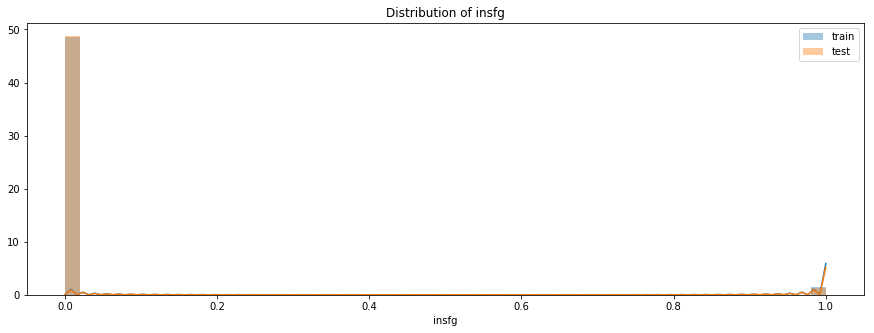

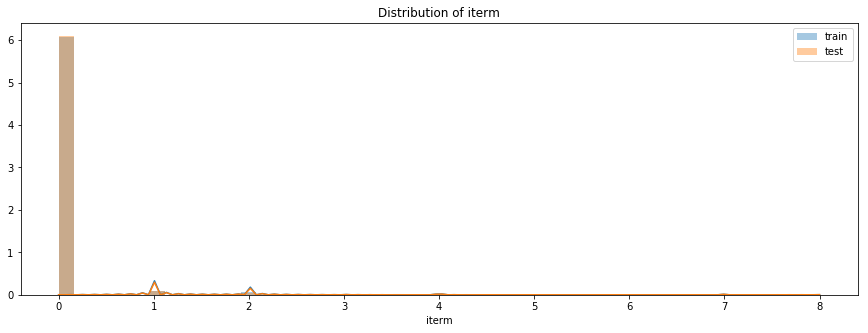

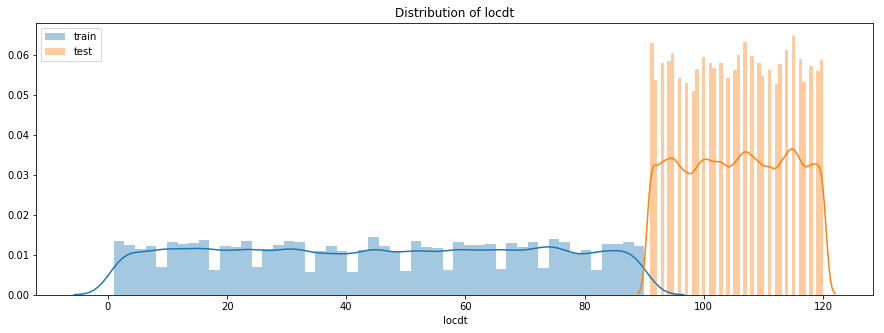

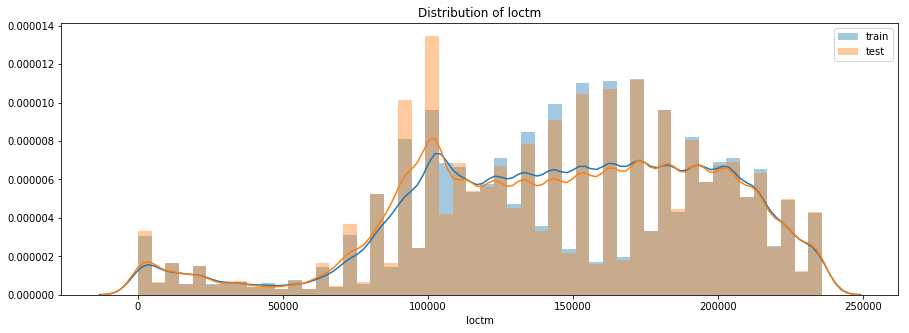

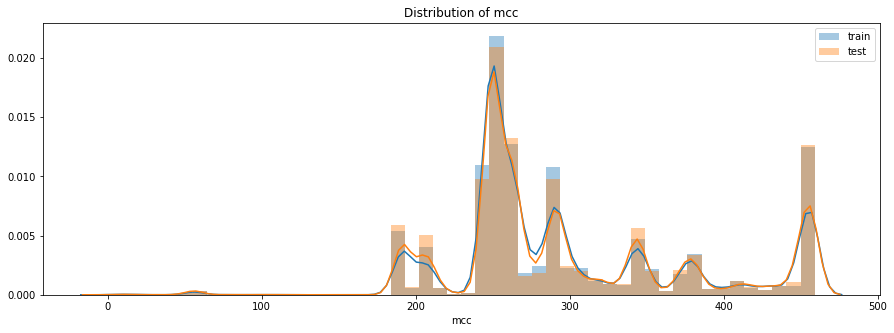

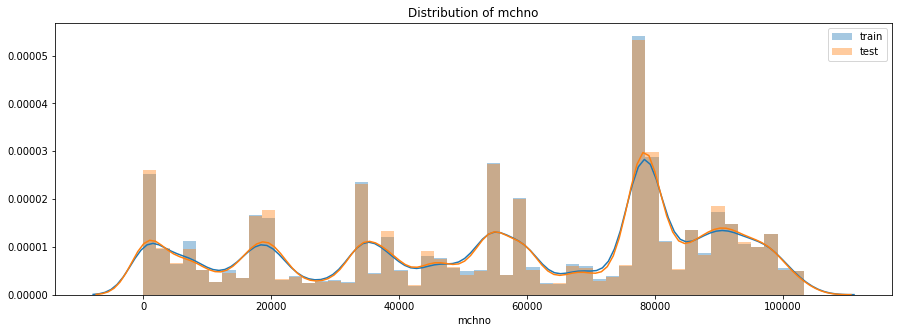

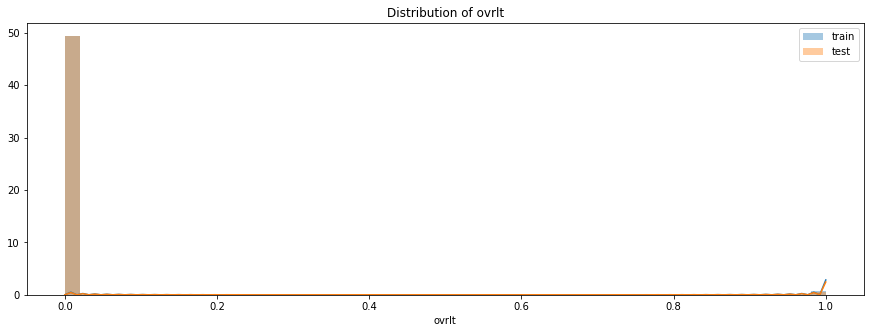

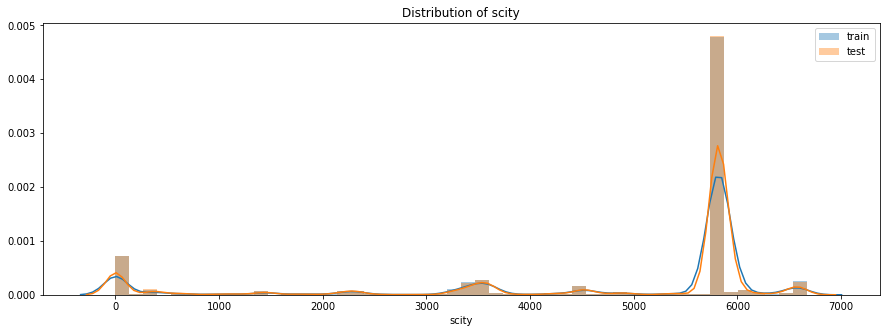

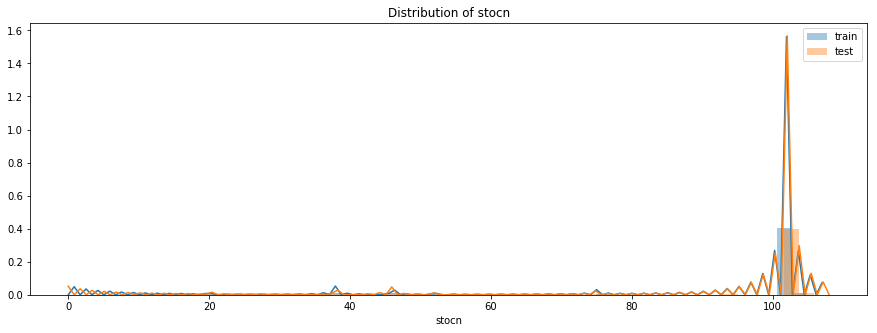

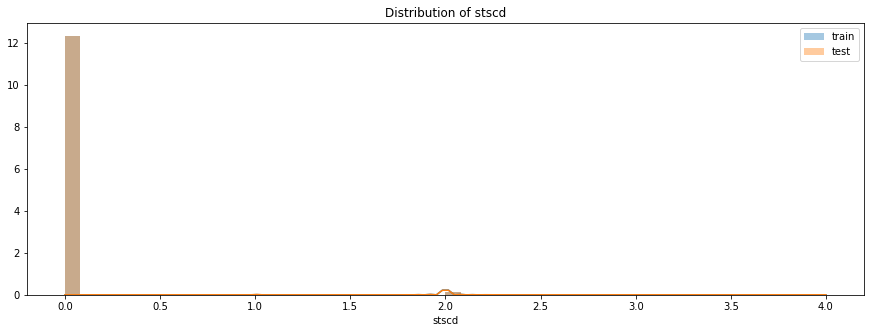

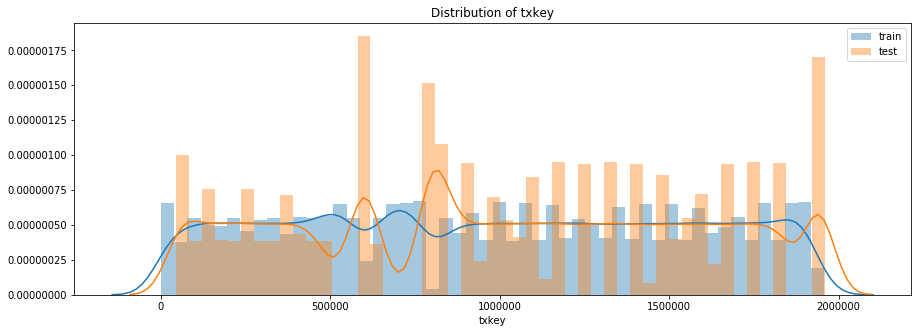

In [111]:
#新 沒做label encoding
df_show = df_validation_2.drop( ['fraud_ind'], axis = 1 )
for i, col  in enumerate(df_show.columns):
    plt.figure(figsize=(15,5))
    sns.distplot(df_validation_2[col], label='train',bins=50);
    sns.distplot(df_test[col], label='test',bins=50);    
    plt.legend();
    plt.title('Distribution of '+col);

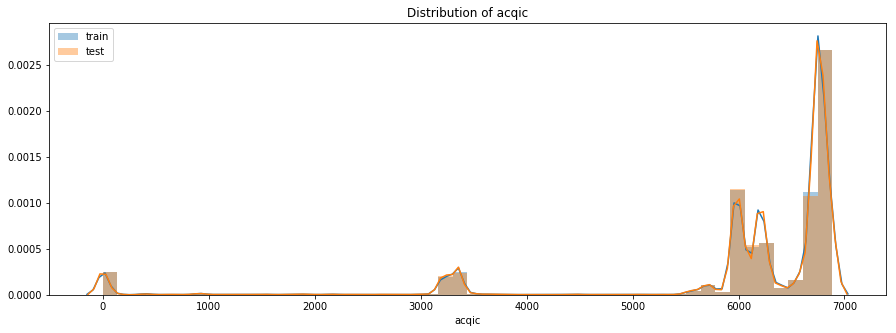

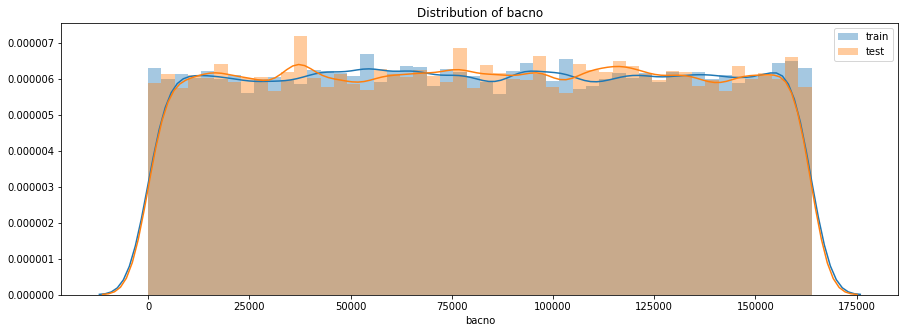

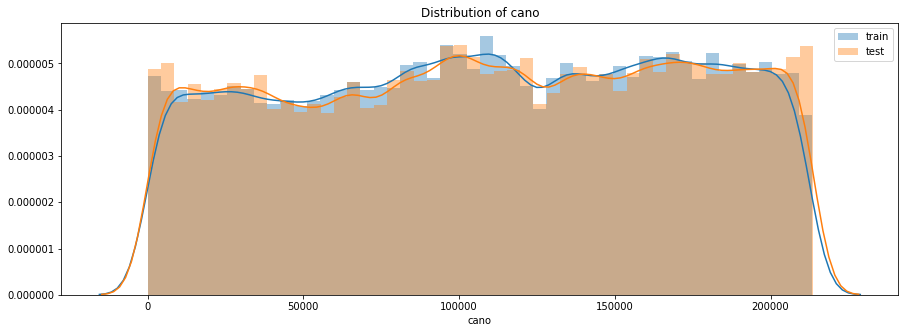

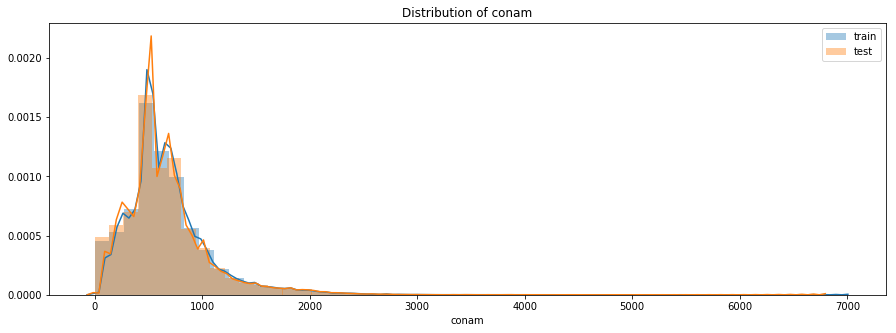

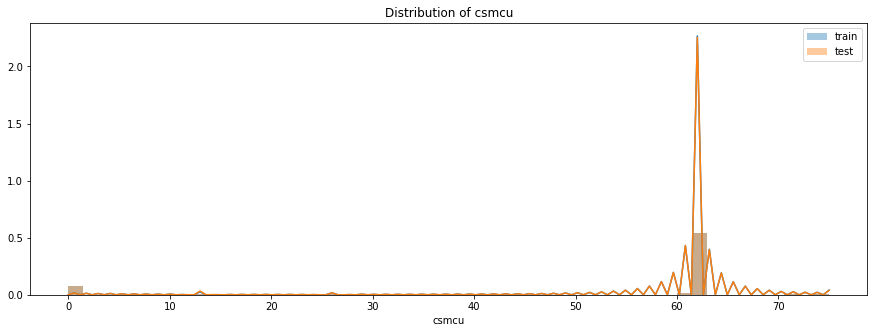

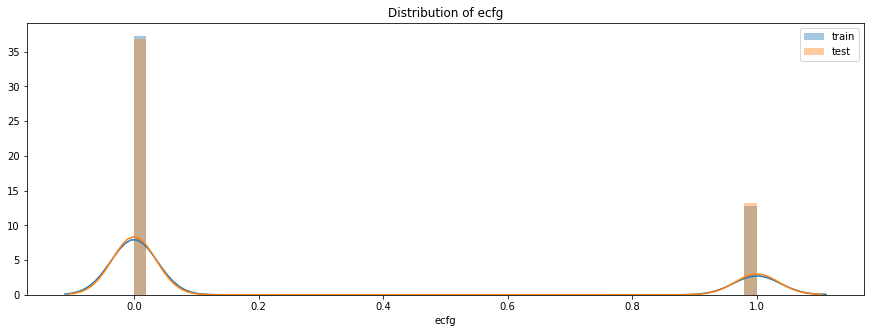

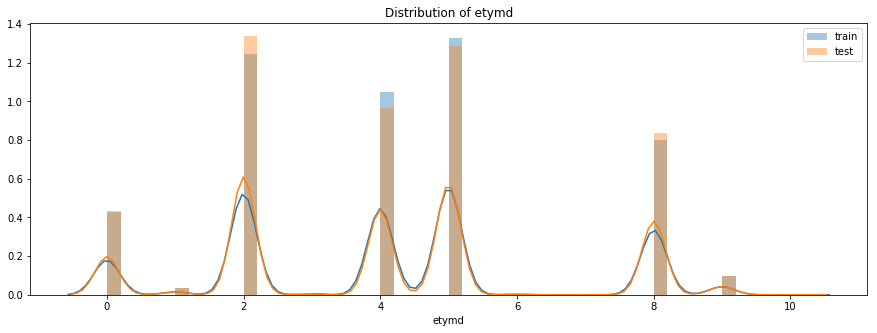

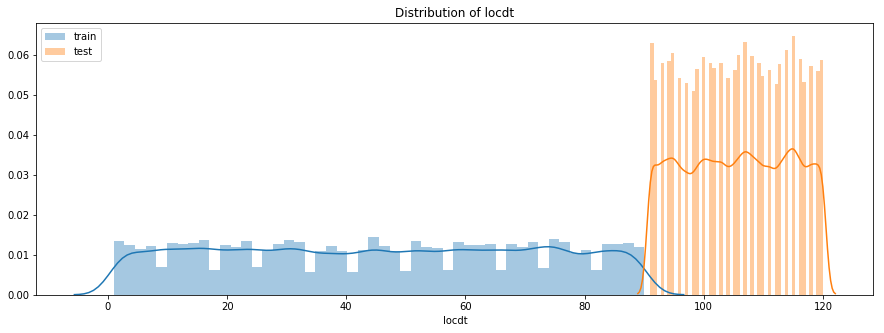

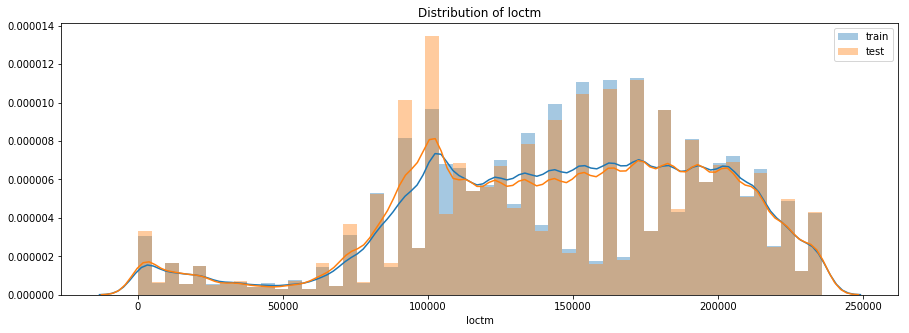

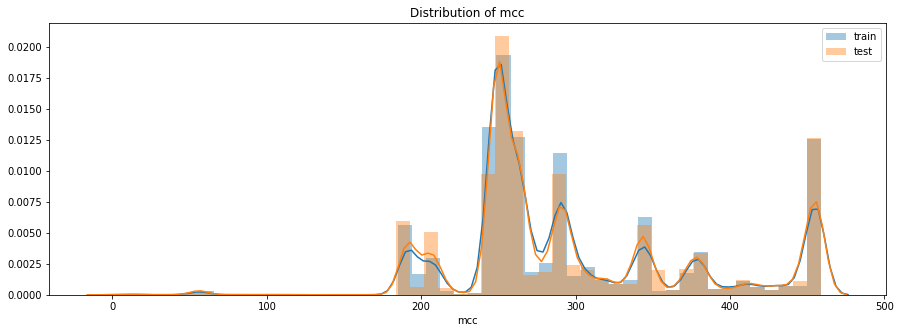

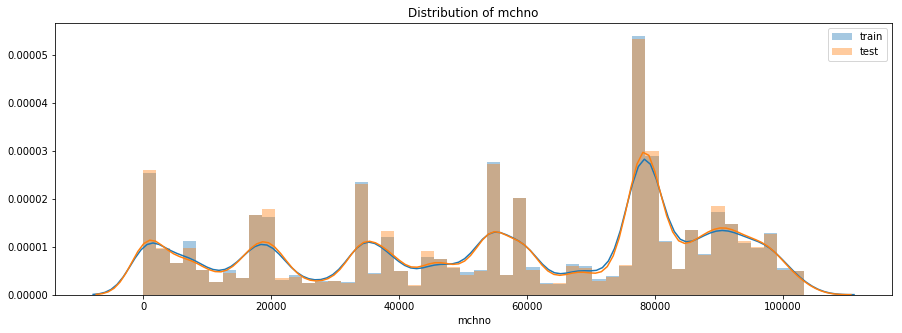

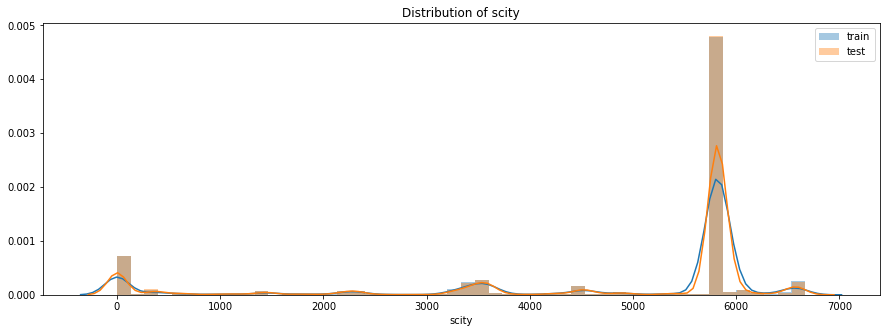

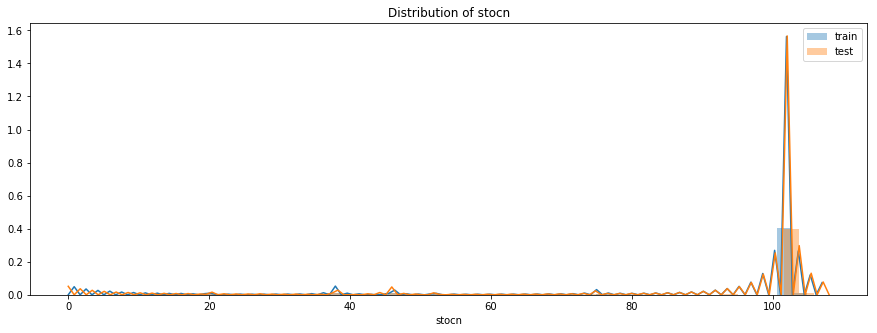

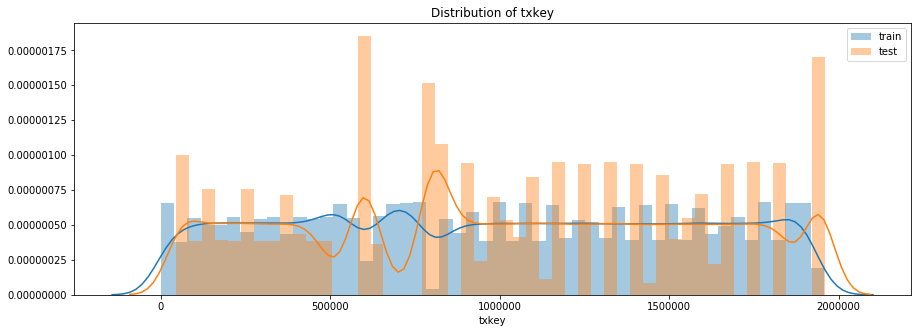

In [68]:
#新 沒做label encoding 11 特徵
df_show = df_validation_2.drop( ['fraud_ind'], axis = 1 )
for i, col  in enumerate(df_show.columns):
    plt.figure(figsize=(15,5))
    sns.distplot(df_validation_2[col], label='train',bins=50);
    sns.distplot(df_test[col], label='test',bins=50);    
    plt.legend();
    plt.title('Distribution of '+col);

In [70]:
df_train_2.to_csv('df_train_2_no_15.csv',index = None)
df_validation_2.to_csv('df_validation_2_no_15.csv',index = None)